## About Dataset

- This dataset contains information about Anime and Otaku who watch it
- This dataset aims to be representative sample of internet otaku community for demographics analysis and trends inside this group. It contains information about users (gender, location, birth date etc.), about anime (airing date, genres, producer…) and anime lists.
Users in MyAnimeList can add anime to their lists, and mark it as plan to watch, completed, watching, dropped…, and they can also rate it by score 1-10.

- AnimeList.csv contains list of anime, with title, title synonyms, genre, studio, licencor, producer, duration, rating, score, airing date, episodes, source (manga, light novel etc.) and many other important data about individual anime providing sufficient information about trends in time about important aspects of anime. Rank is in float format in csv, but it contains only integer value. This is due to NaN values and their representation in pandas.

- UserList.csv contains information about users who watch anime, namely username, registration date (join_date), last online date, birth date, gender, location, and lots of aggregated values from their anime lists.

- UserAnimeList.csv contains anime lists of all users. Per each record, here is username, anime ID, score, status and timestamp when was this record last updated.



# Dataset Summary

- **Unique Users**: 302,675
- **Users with Demographic Data**: 302,573

- **Anime List Records**: 80,076,112
- **Records with Ratings**: 46,358,322

- **Unique Anime**: 14,478


## Real World Machine Learning Problem

In this case study, we are going to use a Hybrid Recommendation System to build a personalized hybrid anime recommender system with the best machine learning algorithms to help recommend new anime to users. Hybrid Recommendation System which is a combination of Content Based Filtering Model and Collaborative Filtering Model helps the model to overcome Cold Start problem and gives a diverse range of recommendations to users. In Hybrid Recommendation System we will be using different KNN algorithms, Vectorization, Matrix Factorization techniques.

## Machine Learning Objective and Constraints

1. The model should have some form of Interpretability when predicting recommendations to users because it helps us to understand model behaviour.

2. Minimize the RMSE and Precision@10 value of each Content Based Filtering and Collaborative Filtering Model that will be combined to build Hybrid Recommendation System Model.

# Importing all the files and libraries

In [1]:
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib 
# matplotlib.use('QtAgg')
# %matplotlib.useinline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
sns.set_style('whitegrid')
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import pickle
from scipy import sparse
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor


import surprise as sp
from surprise import accuracy
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.prediction_algorithms.knns import KNNBaseline
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms.matrix_factorization import NMF

In [2]:
# importing all the three csv files
df_anime = pd.read_csv("/Users/nishchal_mac/Desktop/Data_Science/Anime_Recommender_System/Dataset/data/anime_cleaned.csv", dtype = str)
df_animelists = pd.read_csv("/Users/nishchal_mac/Desktop/Data_Science/Anime_Recommender_System/Dataset/data/animelists_cleaned.csv", dtype = str)
df_users = pd.read_csv("/Users/nishchal_mac/Desktop/Data_Science/Anime_Recommender_System/Dataset/data/users_cleaned.csv", dtype = str)

In [3]:
# dataframe about anime
df_anime.head(3)

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0,2012.0
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0,2007.0
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0,2008.0


In [4]:
# dataframe about rating given by users
df_animelists.head(3)

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:54:51,NaN
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-04-27 16:43:35,NaN


In [5]:
# dataframe about users
df_users.head(3)

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,0,0,55.09166666666667,Female,"Chennai, India",1990-04-29 00:00:00,NaN,2013-03-03 00:00:00,2014-02-04 01:32:00,7.43,0.0,3391
1,Damonashu,37326,45,195,27,25,59,82.57430555555555,Male,"Detroit,Michigan",1991-08-01 00:00:00,NaN,2008-02-13 00:00:00,2017-07-10 06:52:54,6.15,6.0,4903
2,bskai,228342,25,414,2,5,11,159.48333333333332,Male,"Nayarit, Mexico",1990-12-14 00:00:00,NaN,2009-08-31 00:00:00,2014-05-12 16:35:00,8.27,1.0,9701


In [6]:
# checking the shape of df_anime, df_animelists and df_users dataframe
print("df_anime shape : ", df_anime.shape)
print("df_animelists shape : ", df_animelists.shape)
print("df_users shape : ", df_users.shape)

df_anime shape :  (6668, 33)
df_animelists shape :  (31284030, 11)
df_users shape :  (108711, 17)


In [7]:
df_animelists['my_score'] = pd.to_numeric(df_animelists['my_score'], errors='coerce')
df_animelists['my_status'] = pd.to_numeric(df_animelists['my_status'], errors='coerce')
df_animelists['my_last_updated'] = pd.to_datetime(df_animelists['my_last_updated'], errors='coerce')
df_animelists['anime_id'] = pd.to_numeric(df_animelists['anime_id'], errors='coerce')
df_animelists['my_watched_episodes'] = pd.to_numeric(df_animelists['my_watched_episodes'], errors='coerce')

## 1. Data Cleaining

# 1.1 Missing Values

In [8]:
#Checking nul values in Dataset/data/AnimeList.csv file
df_anime.isna().sum()

anime_id              0
title                 0
title_english      3230
title_japanese        5
title_synonyms     2187
image_url             2
type                  0
source                0
episodes              0
status                0
airing                0
aired_string          0
aired                 0
duration              0
rating               82
score                 0
scored_by             0
rank                356
popularity            0
members               0
favorites             0
background         5855
premiered          3702
broadcast          3688
related               0
producer           2266
licensor           3881
studio                0
genre                 4
opening_theme         0
ending_theme          0
duration_min          0
aired_from_year       0
dtype: int64

In [9]:
#Checking nul values in Dataset/data/UserAnimeList.csv file
df_animelists.isna().sum()

username                    243
anime_id                      0
my_watched_episodes           0
my_start_date                 0
my_finish_date                0
my_score                      0
my_status                     0
my_rewatching           6878247
my_rewatching_ep              0
my_last_updated               0
my_tags                29290429
dtype: int64

In [10]:
#Checking nul values in Dataset/data/UserList.csv file
df_users.isna().sum()

username                         1
user_id                          0
user_watching                    0
user_completed                   0
user_onhold                      0
user_dropped                     0
user_plantowatch                 0
user_days_spent_watching         0
gender                           0
location                         5
birth_date                       0
access_rank                 108711
join_date                        0
last_online                      0
stats_mean_score                 0
stats_rewatched                  0
stats_episodes                   0
dtype: int64

If there are lot of null values in particular feature then we have to drop that feature for ease of handling of datasets.

## 1.1.1 Droping Not useful Columns
Droping all the uncessary columns and the columns which contains lot of null value from all the three dataset.

In [11]:
df_anime = df_anime.drop(['title_english','title_japanese','title_synonyms','status','airing','aired_string','aired','duration','rating',
                          'score','scored_by','rank','popularity','members','favorites','background','premiered','broadcast','related','producer',
                          'licensor','opening_theme','ending_theme','duration_min','aired_from_year'], axis = 1)

df_animelists = df_animelists.drop(['my_start_date','my_finish_date','my_rewatching','my_rewatching_ep','my_tags'], axis = 1)

df_users = df_users.drop(['user_watching','user_completed','user_onhold','user_dropped','user_plantowatch','user_days_spent_watching',
                          'access_rank','join_date','last_online','stats_mean_score','stats_rewatched','stats_episodes'], axis = 1)

Again Checking for null values in all the columns in three dataset.

In [12]:
#Checking nul values in Dataset/data/anime_cleaned.csv file
df_anime.isna().sum()

anime_id     0
title        0
image_url    2
type         0
source       0
episodes     0
studio       0
genre        4
dtype: int64

In [13]:
# Checking nul values in Dataset/data/animelists_cleaned.csv file
df_animelists.isna().sum()

username               243
anime_id                 0
my_watched_episodes      0
my_score                 0
my_status                0
my_last_updated          0
dtype: int64

In [14]:
# Checking nul values in Dataset/data/users_cleaned.csv file
df_users.isna().sum()

username      1
user_id       0
gender        0
location      5
birth_date    0
dtype: int64

Checking shpae after dropping certain columns

In [15]:
print("df_anime shape : ", df_anime.shape)
print("df_animelists shape : ", df_animelists.shape)
print("df_users shape : ", df_users.shape)

df_anime shape :  (6668, 8)
df_animelists shape :  (31284030, 6)
df_users shape :  (108711, 5)


## 1.1.2 Droping Rows with Null Values

In [16]:
# droping rows containing null values in df_anime dataframe
df_anime = df_anime.dropna()

# droping rows containing null values in df_animelists dataframe
df_animelists = df_animelists.dropna()

# droping rows containing null values in df_users dataframe
df_users = df_users.dropna()

Cross checking for any null values in all the columns in three dataset.

In [17]:
# Checking null values in Dataset/data/anime_cleaned.csv file
df_anime.isna().sum()

anime_id     0
title        0
image_url    0
type         0
source       0
episodes     0
studio       0
genre        0
dtype: int64

In [18]:
# Checking null values in Dataset/data/animelists_cleaned.csv file
df_animelists.isna().sum()

username               0
anime_id               0
my_watched_episodes    0
my_score               0
my_status              0
my_last_updated        0
dtype: int64

In [19]:
# Checking null values in Dataset/data/users_cleaned.csv file
df_users.isna().sum()

username      0
user_id       0
gender        0
location      0
birth_date    0
dtype: int64

In [20]:
print("df_anime shape : ", df_anime.shape)
print("df_animelists shape : ", df_animelists.shape)
print("df_users shape : ", df_users.shape)

df_anime shape :  (6662, 8)
df_animelists shape :  (31283787, 6)
df_users shape :  (108705, 5)


## 1.2 Removing Duplicate Values
First Checking and then removing if there is any duplicate value in df_anime and df_users dataframe.

In [21]:
# checking for any duplicate anime in df_anime dataframe
duplicate_bool = df_anime.duplicated(['anime_id','title','image_url'])
print("There are {} duplicate Dataset/data/anime_cleaned in the dataset.".format(sum(duplicate_bool)))

There are 0 duplicate Dataset/data/anime_cleaned in the dataset.


In [22]:
# checking for any duplicate username in df_users dataframe
duplicate_bool = df_users.duplicated(['username','user_id']) 
print("There are {} duplicate Username entries in the dataset.".format(sum(duplicate_bool)))

There are 0 duplicate Username entries in the dataset.


**conclusion**: There are no Dublicate entries(anime,username) Present in df_anime and  df_users

## 1.3 Cleaning my_last_updated column in df_animelists dataframe

As it can be seen that my_last_updated column contains last updated date and time.

So to make data handeling easy we will only use last update date and we will remove the last updated time part from the my_last_updated column in df_animelists dataframe.

In [27]:
# First, ensure the column is in datetime format
df_animelists['my_last_updated'] = pd.to_datetime(df_animelists['my_last_updated'], errors='coerce')

# Now, extract the date part
df_animelists['my_last_updated'] = df_animelists['my_last_updated'].dt.date

# Display the first few rows to check the result
print(df_animelists.head(2))

   username  anime_id  my_watched_episodes  my_score  my_status  \
0  karthiga        21                  586         9          1   
1  karthiga        59                   26         7          2   

  my_last_updated  
0      2013-03-03  
1      2013-03-10  


## 1.4 Cleaning birth_date column in df_users dataframe
As it can be seen that birth_date column also contains date and time.

But we only want date part from birth_date column in df_users dataframe, so it can make data handeling easy.

In [28]:
birth_date = df_users['birth_date'].values #extracting birth_date column values containing date and time
birth_date_list = [] #creating an empty list for storing birth_date column date part

#seperating birth_date column date and time part and storing date part
for i in range(len(birth_date)):
    birth_date_list.append(birth_date[i].split(" ")[0])

# finally removing the birth_date column which contain both date and time
df_users = df_users.drop('birth_date', axis=1)

# assigning new column with only date part from birth_date column
df_users = df_users.assign(birth_date = birth_date_list)

df_users.head(2)

,username,user_id,gender,location,birth_date
0,karthiga,2255153,Female,"Chennai, India",1990-04-29
1,Damonashu,37326,Male,"Detroit,Michigan",1991-08-01


## 1.5 Cleaning rows having outlier value of my_last_updated column in df_animelists
We are cleaning my_last_updated column in df_animelists because it may contain date which are not realistic.

In [29]:
# checking my_last_updated column by sorting the df_animelists dataframe w.r.t my_last_updated
df_animelists.sort_values(by='my_last_updated', inplace=True)
df_animelists.head()

,username,anime_id,my_watched_episodes,my_score,my_status,my_last_updated
4013734,Ixio,688,0,0,6,1970-01-01
1750556,Chued,1913,0,0,6,1970-01-01
1750545,Chued,1519,12,9,2,1970-01-01
334922,Swarnadeep,1575,25,5,2,1970-01-01
334923,Swarnadeep,1686,1,6,2,1970-01-01


It can be observed that my_last_updated column contains date that goes back to 1970-01-01 which is not possible as the website MyAnimeList itself starts from 2004-11-05, so having a my_last_updated as 1970-01-01 or any date before 2004-11-05 is not possible and it needs to be removed.

So let's plot the distribution of my_last_updated column in df_animelists dataframe.

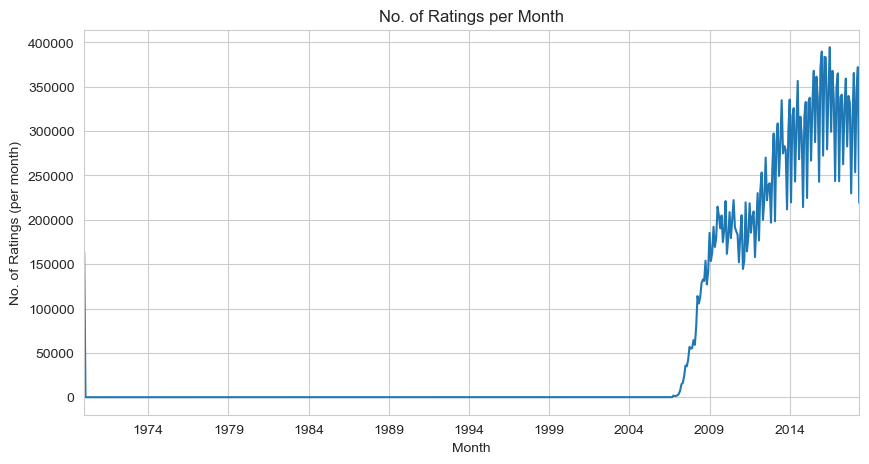

In [30]:
# plotting distribution of my_last_updated column in df_animelists dataframe
df_animelists['my_last_updated'] = pd.to_datetime(df_animelists['my_last_updated'])
df_animelists.resample('M', on='my_last_updated')['my_score'].count().plot(figsize = (10,5), title = "No. of Ratings per Month")
plt.xlabel('Month')
plt.ylabel('No. of Ratings (per month)')
plt.show()

*Observation*: Observing the graph it seems that my_last_updated column only has 1970-01-01 date as outlier and no other outlier date is in between the date 1970-01-01 and 2004-11-05 .

In [31]:
# checking datapoints having 1970-01-01 date in my_last_updated column in df_animelists dataframe
df_animelists[df_animelists['my_last_updated'] == '1970-01-01']

,username,anime_id,my_watched_episodes,my_score,my_status,my_last_updated
4013734,Ixio,688,0,0,6,1970-01-01
1750556,Chued,1913,0,0,6,1970-01-01
1750545,Chued,1519,12,9,2,1970-01-01
334922,Swarnadeep,1575,25,5,2,1970-01-01
334923,Swarnadeep,1686,1,6,2,1970-01-01
...,...,...,...,...,...,...
2871610,MisterYoda,92,39,6,2,1970-01-01
25757454,Clay_e07,2236,1,9,2,1970-01-01
2328771,thuyquai,856,0,5,4,1970-01-01
2328766,thuyquai,177,0,0,4,1970-01-01


In [32]:
# droping the rows having 1970-01-01 date in my_last_updated column in df_animelists dataframe
df_animelists = df_animelists.drop(index = df_animelists[df_animelists['my_last_updated'] == '1970-01-01'].index.tolist(), axis = 0)
df_animelists.head(2)

,username,anime_id,my_watched_episodes,my_score,my_status,my_last_updated
24994054,martino,65,12,9,2,2006-09-27
5300,Xinil,396,4,0,4,2006-09-27


In [33]:
# checking the shape of df_animelists dataframe after data cleaning
df_animelists.shape

(31120556, 6)

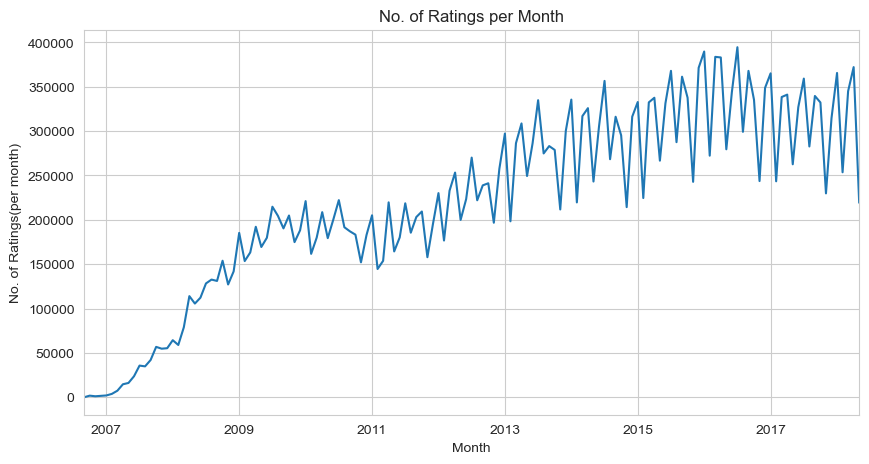

In [34]:
# Again plotting distribution of my_last_updated column after removing outlier dates
df_animelists.resample('M', on='my_last_updated')['my_score'].count().plot(figsize = (10,5), title = 'No. of Ratings per Month')
plt.xlabel('Month')
plt.ylabel('No. of Ratings(per month)')
plt.show()

## 1.6 Cleaning rows w.r.t. my_score column in df_animelists dataframe

In [35]:
df_animelists.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31120556 entries, 24994054 to 28747995
Data columns (total 6 columns):
 #   Column               Dtype         
---  ------               -----         
 0   username             object        
 1   anime_id             int64         
 2   my_watched_episodes  int64         
 3   my_score             int64         
 4   my_status            int64         
 5   my_last_updated      datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 1.6+ GB


In [36]:
df_animelists.head()

,username,anime_id,my_watched_episodes,my_score,my_status,my_last_updated
24994054,martino,65,12,9,2,2006-09-27
5300,Xinil,396,4,0,4,2006-09-27
8549214,Aokaado,50,9,6,4,2006-09-27
8549194,Aokaado,846,26,10,2,2006-09-27
4771722,Condoriano,986,1,7,2,2006-09-27


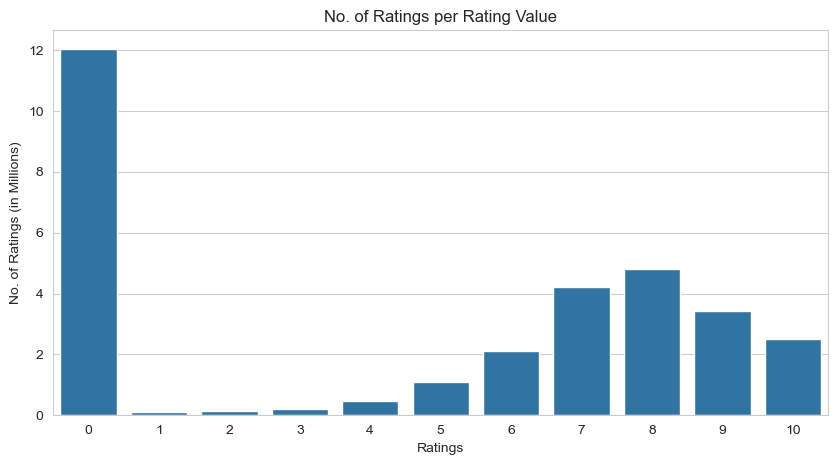

In [37]:
# plotting and checking the distribution of my_score column in df_animelists dataframe
# Set up the figure and axis with the desired figsize
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the count of each rating value in the 'my_score' column
sns.countplot(x='my_score', data=df_animelists, ax=ax)

# Set the title and labels
plt.title('No. of Ratings per Rating Value')
plt.xlabel('Ratings')

# Format the y-axis to show values in millions
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x / 1e6))
ax.yaxis.set_major_formatter(ticks_y)
plt.ylabel('No. of Ratings (in Millions)')

# Show the plot
plt.show()

In [38]:
df_animelists[df_animelists['my_score']==0]

,username,anime_id,my_watched_episodes,my_score,my_status,my_last_updated
5300,Xinil,396,4,0,4,2006-09-27
5101077,hazte,1136,0,0,6,2006-09-28
8603762,Aiko,106,0,0,6,2006-09-28
28558769,p2thej115,917,1,0,2,2006-09-29
2018231,Dragon_Empress,1026,0,0,6,2006-09-29
...,...,...,...,...,...,...
16931489,Kurotsugu-san,387,0,0,6,2018-05-22
23734886,iRemorse,36475,0,0,1,2018-05-22
17006037,MatheusAlexandre,31240,3,0,1,2018-05-22
23652395,fabled_courier,569,0,0,6,2018-05-22


*Observation*: As it can be seen from the my_score column distribution that my_score with 0 value has huge number of distibution.

But on MyAnimeList website the user can only rate anime between the scale of 1 to 10. So all the rows having value of my_score equals to 0 has no significance and we have to remove such rows.

In [39]:
# checking the total number of rows having my_score value equals to 0 in df_animelists dataframe
df_animelists[df_animelists['my_score'] == 0].shape

(12045699, 6)

In [40]:
# dropping all rows having my_score value equal to 0 in df_animelists dataframe
df_animelists = df_animelists.drop(df_animelists[df_animelists['my_score'] == 0].index.tolist(), axis = 0)
df_animelists.shape

(19074857, 6)

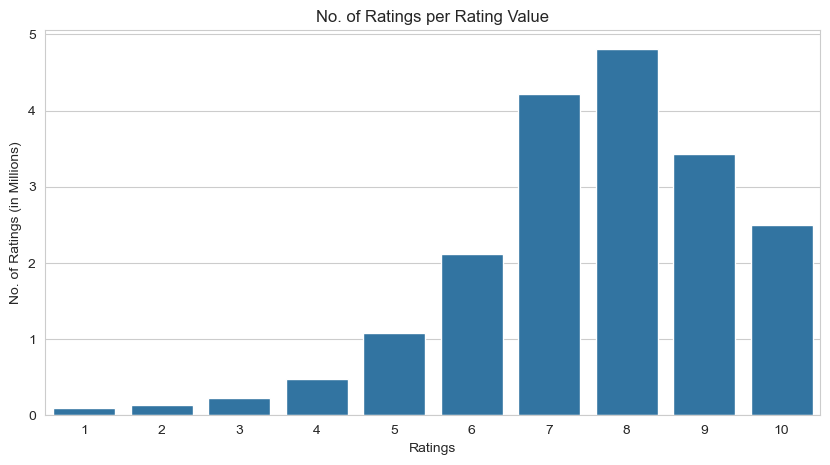

In [41]:
# after cleaning again plotting the distribution of my_score column in df_animelists dataframe
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the count of each rating value in the 'my_score' column
sns.countplot(x='my_score', data=df_animelists, ax=ax)

# Set the title and labels
plt.title('No. of Ratings per Rating Value')
plt.xlabel('Ratings')

# Format the y-axis to show values in millions
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x / 1e6))
ax.yaxis.set_major_formatter(ticks_y)
plt.ylabel('No. of Ratings (in Millions)')

# Show the plot
plt.show()

## 1.7 Cleaning rows with respect to my_status column in df_animelists
my_status colummn in animelists tables contains integer values and their semantics are:

1: watching
2: completed
3: on hold
4: dropped
6: plan to watch

We will first check the my_status column and if their are any other values apart from 1, 2, 3, 4 and 6 then we will remove such rows from df_animelists dataframe.


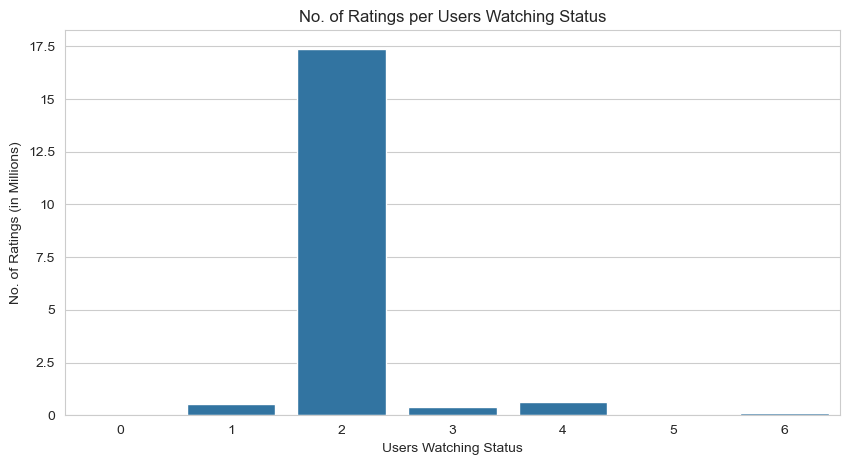

In [42]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))  # Added figsize to set the plot size

# Plot the count of each status in the 'my_status' column
sns.countplot(x='my_status', data=df_animelists, ax=ax)

# Set the title and labels
plt.title('No. of Ratings per Users Watching Status')
plt.xlabel('Users Watching Status')

# Format the y-axis to show values in millions
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x / 1e6))
ax.yaxis.set_major_formatter(ticks_y)
plt.ylabel('No. of Ratings (in Millions)')

# Show the plot
plt.show()

*observation*: We need to remove rows having my_status value equal to 0 and 5, as it does not have any known significance to it.

In [43]:
# checking the total number of rows having my_status value equals to 0 in df_animelists dataframe
df_animelists[df_animelists['my_status'] == 0].shape

(51, 6)

In [44]:
# checking the total number of rows having my_status value equals to 5 in df_animelists dataframe
df_animelists[df_animelists['my_status'] == 5]

,username,anime_id,my_watched_episodes,my_score,my_status,my_last_updated
7988959,tappe,3927,25,7,5,2009-03-31


In [45]:
# droping all the rows having my_status values equal to 0 and 5 in df_animelists dataframe
df_animelists = df_animelists.drop(df_animelists[df_animelists['my_status'] == 0].index.tolist(), axis = 0)
df_animelists = df_animelists.drop(df_animelists[df_animelists['my_status'] == 5].index.tolist(), axis = 0)

In [46]:
# checking the shape of df_animelists dataframe after data cleaning
df_animelists.shape

(19074805, 6)

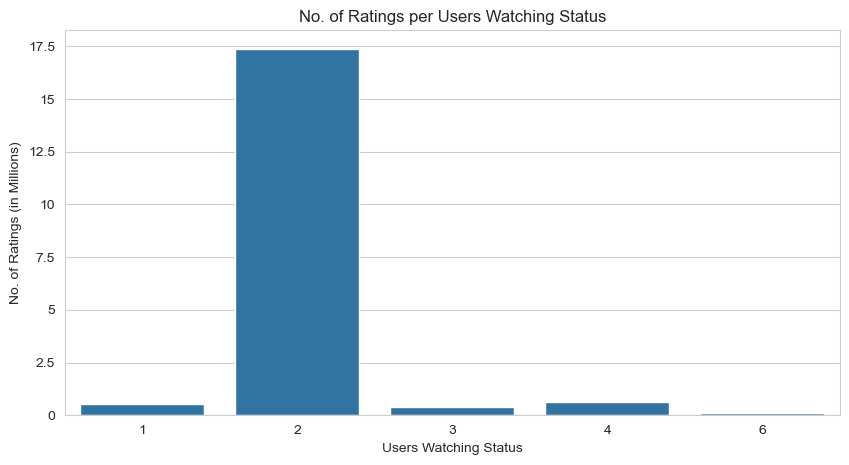

In [47]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))  # Added figsize to set the plot size

# Plot the count of each status in the 'my_status' column
sns.countplot(x='my_status', data=df_animelists, ax=ax)

# Set the title and labels
plt.title('No. of Ratings per Users Watching Status')
plt.xlabel('Users Watching Status')

# Format the y-axis to show values in millions
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x / 1e6))
ax.yaxis.set_major_formatter(ticks_y)
plt.ylabel('No. of Ratings (in Millions)')

# Show the plot
plt.show()

## 2.  Statistics on cleaned dataset

In [48]:
# printing total number of rating, users and anime from the cleaned df_animelists dataframe
print("Total No of Ratings in df_animelists dataframe :", len(df_animelists))
print("Total No of Users in df_animelists dataframe   :", len(np.unique(df_animelists.username)))
print("Total No of Animes in df_animelists dataframe  :", len(np.unique(df_animelists.anime_id)))

Total No of Ratings in df_animelists dataframe : 19074805
Total No of Users in df_animelists dataframe   : 106353
Total No of Animes in df_animelists dataframe  : 6598


In [51]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6662 entries, 0 to 6667
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   anime_id   6662 non-null   object
 1   title      6662 non-null   object
 2   image_url  6662 non-null   object
 3   type       6662 non-null   object
 4   source     6662 non-null   object
 5   episodes   6662 non-null   object
 6   studio     6662 non-null   object
 7   genre      6662 non-null   object
dtypes: object(8)
memory usage: 468.4+ KB


In [53]:
df_anime.head(2)

,anime_id,title,image_url,type,source,episodes,studio,genre
0,11013,Inu x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,David Production,"Comedy, Supernatural, Romance, Shounen"
1,2104,Seto no Hanayome,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Gonzo,"Comedy, Parody, Romance, School, Shounen"


In [54]:
num_l=['anime_id','episodes']
for i in num_l: df_anime[i]=pd.to_numeric(df_anime[i], errors='coerce')

In [55]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6662 entries, 0 to 6667
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   anime_id   6662 non-null   int64 
 1   title      6662 non-null   object
 2   image_url  6662 non-null   object
 3   type       6662 non-null   object
 4   source     6662 non-null   object
 5   episodes   6662 non-null   int64 
 6   studio     6662 non-null   object
 7   genre      6662 non-null   object
dtypes: int64(2), object(6)
memory usage: 468.4+ KB


In [56]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108705 entries, 0 to 108710
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   username    108705 non-null  object
 1   user_id     108705 non-null  object
 2   gender      108705 non-null  object
 3   location    108705 non-null  object
 4   birth_date  108705 non-null  object
dtypes: object(5)
memory usage: 5.0+ MB


In [57]:
df_users.head(2)

,username,user_id,gender,location,birth_date
0,karthiga,2255153,Female,"Chennai, India",1990-04-29
1,Damonashu,37326,Male,"Detroit,Michigan",1991-08-01


In [58]:
df_users['user_id']=pd.to_numeric(df_users['user_id'], errors='coerce')
df_users['birth_date']=pd.to_datetime(df_users['birth_date'], errors='coerce')

In [59]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108705 entries, 0 to 108710
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   username    108705 non-null  object        
 1   user_id     108705 non-null  int64         
 2   gender      108705 non-null  object        
 3   location    108705 non-null  object        
 4   birth_date  108705 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 5.0+ MB


In [60]:
# printing total number of animes in the cleaned df_anime dataframe
print("Total No of Animes in df_anime dataframe  :", len(np.unique(df_anime.anime_id)))

# printing total number of users in the cleaned df_users dataframe
print("Total No of Animes in df_anime dataframe  :", len(np.unique(df_users.username)))

Total No of Animes in df_anime dataframe  : 6662
Total No of Animes in df_anime dataframe  : 108705


In [61]:
# mean my_score value of all users
print("Mean value of all the rating given by the user  : ",df_animelists['my_score'].mean())

Mean value of all the rating given by the user  :  7.592238557615661


## 3. Data Splitting

# 3.1 Concatinating all the three dataframe
Checking all the three dataframe before concatinating into single dataframe.

We will be droping image_url column in df_anime dataframe because it does not have any use in building ml model and its just for showing image of anime poster.

In [62]:
# concatinating df_animelists and df_anime dataframe using anime_id as common column in both dataframe
df = pd.merge(df_animelists, df_anime.drop(['image_url'], axis = 1), on = 'anime_id')

# now concatinating df_users dataframe using username as common column in both dataframe4
df = pd.merge(df, df_users.drop(['location','birth_date'], axis = 1), on = 'username')
df.head(2)

,username,anime_id,my_watched_episodes,my_score,my_status,my_last_updated,title,type,source,episodes,studio,genre,user_id,gender
0,martino,65,12,9,2,2006-09-27,Rozen Maiden: Träumend,TV,Manga,12,Nomad,"Action, Comedy, Drama, Magic, Seinen",390,Male
1,Aokaado,50,9,6,4,2006-09-27,Aa! Megami-sama! (TV),TV,Manga,24,AIC,"Comedy, Supernatural, Magic, Romance, Seinen",3,Male


In [63]:
# Saving the resulting dataframe to a CSV file
df.to_csv('merged_df.csv', index=False)

In [64]:
# checking the shape of final concatinated dataframe
df.shape

(19073095, 14)

## 3.2 Spliting dataset into train and test

We will be splitting our final concatinated dataframe using my_last_updated column.

We will be first sorting the dataframe w.r.t. my_last_updated column and then we will split the final concatinated dataframe into 80:20 ratio for train and test dataset respectively.

Here basically we are doing the time-series spliting of the dataset based on users last updated date for rating a particular anime, in which we will be using first 80% of data that user has last updated as training dataset and remaining 20% dataset as test dataset.

In [65]:
# sorting the dataframe dased on my_last_updated column
df.sort_values(by='my_last_updated', inplace=True)

# spliting dataframe into train and test dataframe
df_train = df.iloc[:int(df.shape[0]*0.80)]
df_test = df.iloc[int(df.shape[0]*0.80):]

print("df_train shape :", df_train.shape)
print("df_test shape :", df_test.shape)

df_train shape : (15258476, 14)
df_test shape : (3814619, 14)


In [66]:
# checking train dataframe
df_train.head(2)

,username,anime_id,my_watched_episodes,my_score,my_status,my_last_updated,title,type,source,episodes,studio,genre,user_id,gender
0,martino,65,12,9,2,2006-09-27,Rozen Maiden: Träumend,TV,Manga,12,Nomad,"Action, Comedy, Drama, Magic, Seinen",390,Male
1,Aokaado,50,9,6,4,2006-09-27,Aa! Megami-sama! (TV),TV,Manga,24,AIC,"Comedy, Supernatural, Magic, Romance, Seinen",3,Male


In [67]:
# checking test dataframe
df_test.head(2)

,username,anime_id,my_watched_episodes,my_score,my_status,my_last_updated,title,type,source,episodes,studio,genre,user_id,gender
15255941,Hawkstar978,30015,13,8,2,2016-07-07,ReLIFE,TV,Web manga,13,TMS Entertainment,"Slice of Life, Romance, School",4441287,Male
15255940,delaverno,28623,12,8,2,2016-07-07,Koutetsujou no Kabaneri,TV,Original,12,Wit Studio,"Action, Drama, Fantasy, Horror",45817,Male


## 3.3 Statistics on Train Dataset

In [68]:
# printing total number of rating, users and anime in train dataset
print("Total No of Ratings in Training Dataset :", len(df_train))
print("Total No of Users in Training Dataset   :", len(np.unique(df_train.username)))
print("Total No of Animes in Training Dataset  :", len(np.unique(df_train.anime_id)))

Total No of Ratings in Training Dataset : 15258476
Total No of Users in Training Dataset   : 99171
Total No of Animes in Training Dataset  : 5594


In [69]:
# calculating mean value of my_score column in df_train dataframe
print("Mean value of all the rating given by the user in Training Dataset : ", df_train['my_score'].mean())

Mean value of all the rating given by the user in Training Dataset :  7.625716028258655


## 3.4  Statistics on Test Dataset

In [70]:
# printing total number of rating, users and anime in test dataset
print("Total No of Ratings in Test Dataset :", len(df_test))
print("Total No of Users in Test Dataset   :", len(np.unique(df_test.username)))
print("Total No of Animes in Test Dataset  :", len(np.unique(df_test.anime_id)))

Total No of Ratings in Test Dataset : 3814619
Total No of Users in Test Dataset   : 56789
Total No of Animes in Test Dataset  : 6552


In [71]:
# calculating mean value of my_score column in df_test dataframe
print("Mean value of all the rating given by the user in Test Dataset : ", df_test['my_score'].mean())

Mean value of all the rating given by the user in Test Dataset :  7.458522332112329


## 4. Exploratory Data Analysis

# 4.1 Distribution of Ratings given by Users

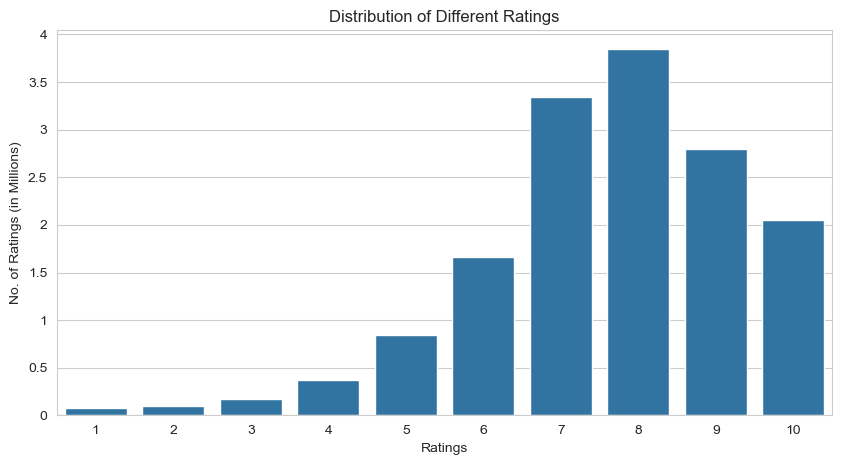

In [72]:
# plotting the distribution of my_score column in training dataset
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the count of each rating value in 'my_score'
sns.countplot(x='my_score', data=df_train, ax=ax)

# Set the title and labels
plt.title('Distribution of Different Ratings')
plt.xlabel('Ratings')

# Format the y-axis to show values in millions
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x / 1e6))
ax.yaxis.set_major_formatter(ticks_y)

# Label the y-axis
plt.ylabel('No. of Ratings (in Millions)')

# Show the plot
plt.show()

*observation*: It can be observed that most rated value in train dataset by users is 8.

# 4.2 Number of Rating given by Users per Month

Text(0, 0.5, 'No. of Ratings')

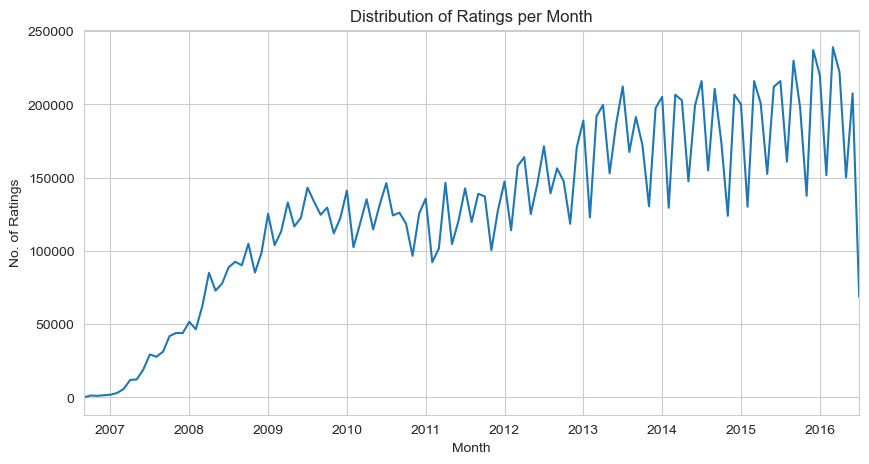

In [73]:
# plotting distribution of my_last_updated column in df_animelists dataframe
df_train.resample('M', on='my_last_updated')['my_score'].count().plot(figsize = (10,5), title = 'Distribution of Ratings per Month')
plt.xlabel('Month')
plt.ylabel('No. of Ratings')

*observation*: It can be seen that the Rating given by Users on Anime has been increasing over the years.

# 4.3 Analysis of Ratings given by Users

In [74]:
# creating the dataset of toatal number of animes rated by each users in decreasing order
anime_rated_by_users = df_train.groupby(by = 'username')['my_score'].count().sort_values(ascending = False)
anime_rated_by_users

username
_thiagobrisolla    2845
Kannei             2716
Shouichirou        2701
GrumpyAnimeSnob    2595
ShanaFlame         2588
                   ... 
Felini                1
RRS_007               1
REVIKATYA             1
keviceaia             1
anecdot11             1
Name: my_score, Length: 99171, dtype: int64

*observation*:
- The most number of animes rated by a single user in training dataset is 2845 animes.
- The least number of anime rated by a single user in training dataset is 1.

In [75]:
print('Total Number of unqiue Users in Training Dataset : ', len(anime_rated_by_users))

Total Number of unqiue Users in Training Dataset :  99171


Text(0.5, 1.0, 'PDF')

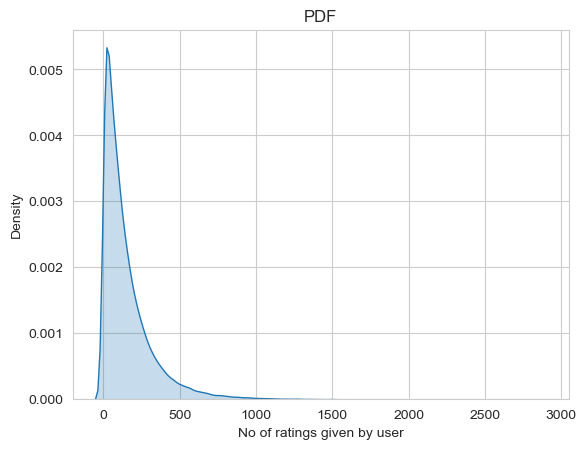

In [76]:
# plotting PDF of no. of rating given by different user 
sns.kdeplot(anime_rated_by_users, shade=True)
plt.xlabel('No of ratings given by user')
plt.title("PDF")

Text(0, 0.5, 'No. of Animes User has Rated')

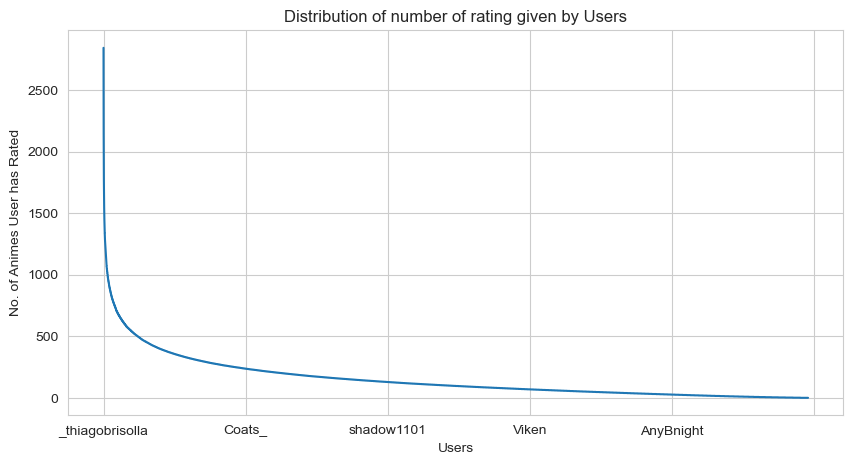

In [77]:
# plotting distribution graph of no. of rating given by unique users 
anime_rated_by_users.plot(figsize=(10,5), title = 'Distribution of number of rating given by Users')
plt.xlabel('Users')
plt.ylabel('No. of Animes User has Rated')

*observation*: We can observed that it is a very skewed graph.

It means that the training dataset have some users who have rated huge number of anime.

In [78]:
# finding the statistical details about the anime_rated_by_users dataframe
anime_rated_by_users.describe()

count    99171.000000
mean       153.860262
std        180.829956
min          1.000000
25%         38.000000
50%         97.000000
75%        204.000000
max       2845.000000
Name: my_score, dtype: float64

In [79]:
# finding the quantile range of anime_rated_by_users dataset
quantiles = anime_rated_by_users.quantile(np.arange(0,1.01,0.01), interpolation='higher')
quantiles[::5]

0.00       1
0.05       5
0.10      12
0.15      20
0.20      29
0.25      38
0.30      48
0.35      59
0.40      71
0.45      84
0.50      97
0.55     113
0.60     131
0.65     151
0.70     174
0.75     204
0.80     239
0.85     286
0.90     359
0.95     495
1.00    2845
Name: my_score, dtype: int64

## 4.4 Analysis of Animes as Rating given by Users

In [80]:
# creating the dataset of toatal number of rating given to each anime in decreasing order
ratings_per_anime = df_train.groupby('title')['my_score'].count().sort_values(ascending=False)
ratings_per_anime.head(5)

title
Death Note                         61549
Code Geass: Hangyaku no Lelouch    47130
Naruto                             46960
Elfen Lied                         45983
Sword Art Online                   44796
Name: my_score, dtype: int64

In [81]:
ratings_per_anime.tail()

title
Kaitou Joker 4th Season                               1
Jakusansei Million Arthur                             1
Isobe Isobee Monogatari: Ukiyo wa Tsurai yo (2015)    1
Imakara Atashi......                                  1
ēlDLIVE                                               1
Name: my_score, dtype: int64

*observation*: It seems that Death Note is the most popular and rated Anime by Users.

In [82]:
print('Total no. of Anime in training dataset : ', len(ratings_per_anime))

Total no. of Anime in training dataset :  5594


Text(0.5, 1.0, 'PDF')

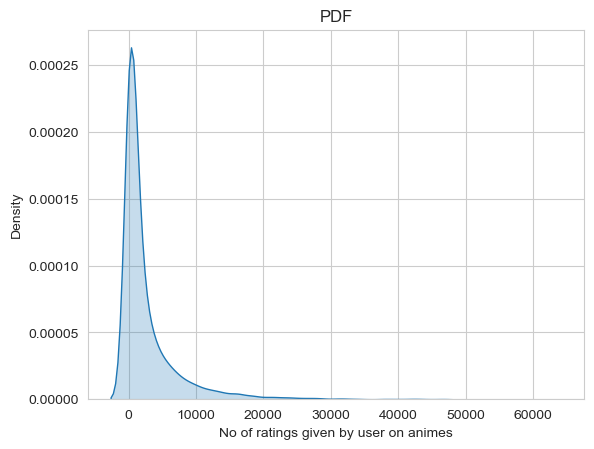

In [83]:
# plotting PDF of no. of rating given by user on different anime 
sns.kdeplot(ratings_per_anime, shade=True)
plt.xlabel('No of ratings given by user on animes')
plt.title("PDF")

Text(0, 0.5, 'No of Users who rated a Anime')

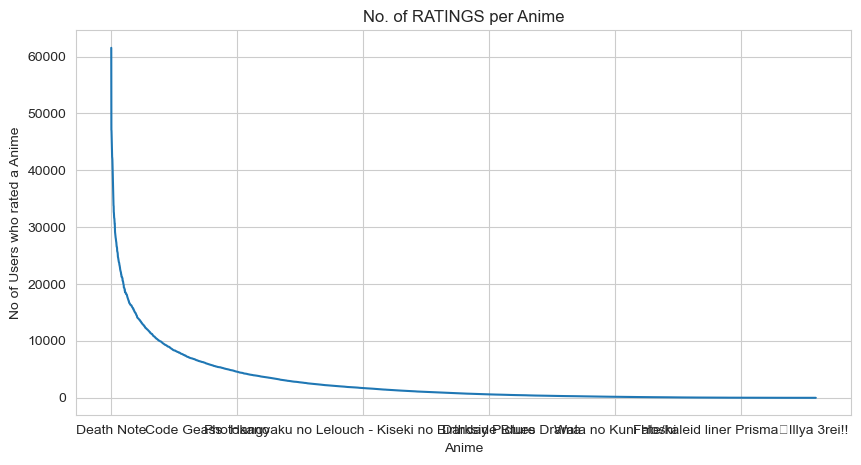

In [84]:
# plotting distribution graph of no. of rating given on each anime
ratings_per_anime.plot(figsize=(10,5), title = 'No. of RATINGS per Anime')
plt.xlabel('Anime')
plt.ylabel('No of Users who rated a Anime')

*observation*: We can observed that it is a very skewed graph.

It shows that the training dataset have some anime which are rated by huge number users.

In [85]:
# finding the statistical details about the ratings_per_anime dataframe
ratings_per_anime.describe()

count     5594.00000
mean      2727.65034
std       4977.93689
min          1.00000
25%        132.25000
50%        756.50000
75%       2996.75000
max      61549.00000
Name: my_score, dtype: float64

## 4.5 Analysis of Rating on Users Watching Status
my_status column contains integer values and their semantics are:

1: watching
2: completed
3: on hold
4: dropped
6: plan to watch

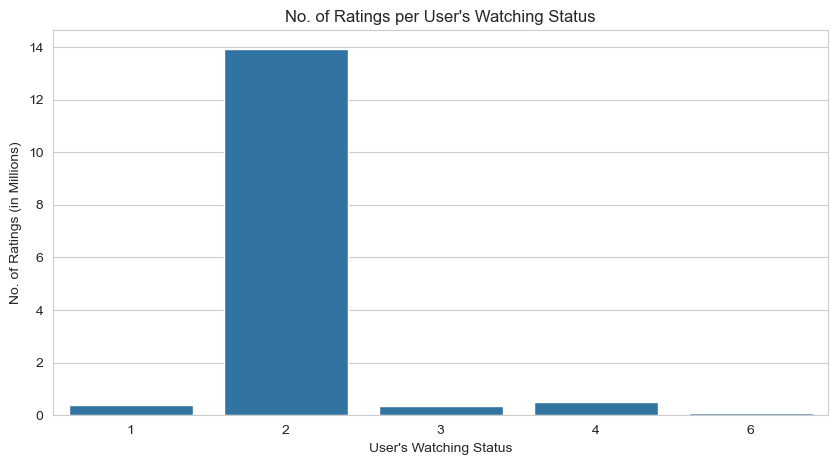

In [87]:
# plotting the distribution graph between users watching status vs no of rating by users
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the count of each watching status in 'my_status'
sns.countplot(x='my_status', data=df_train, ax=ax)

# Set the title and labels
plt.title('No. of Ratings per User\'s Watching Status')
plt.xlabel('User\'s Watching Status')

# Format the y-axis to show values in millions
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x / 1e6))
ax.yaxis.set_major_formatter(ticks_y)

# Label the y-axis
plt.ylabel('No. of Ratings (in Millions)')

# Show the plot
plt.show()

*obervation*: The above above graph shows that the most users who has rated an anime has completed watching that particular anime.

It also helps the training dataset which means most of the rating by users are given when they have completely watched the anime and not half watched the anime.

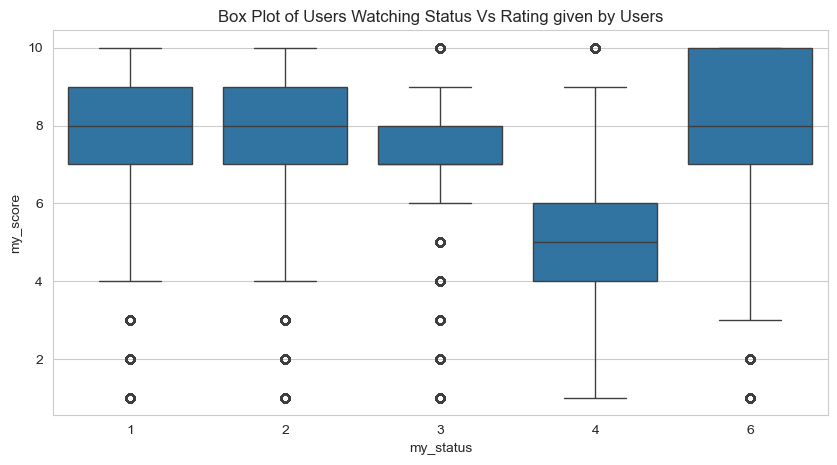

In [88]:
# plotting Box Plot between users watching status vs rating given by users
fig = plt.figure(figsize = (10,5))
sns.boxplot(x='my_status', y ='my_score', data=df_train)
plt.title('Box Plot of Users Watching Status Vs Rating given by Users')
plt.show()

*observation*: From the above Box Plot we can clearly see that Inter Quantile Range(IQR) of my_status equals to 4 is very seperated from Inter Quantile Range of other values of my_status.

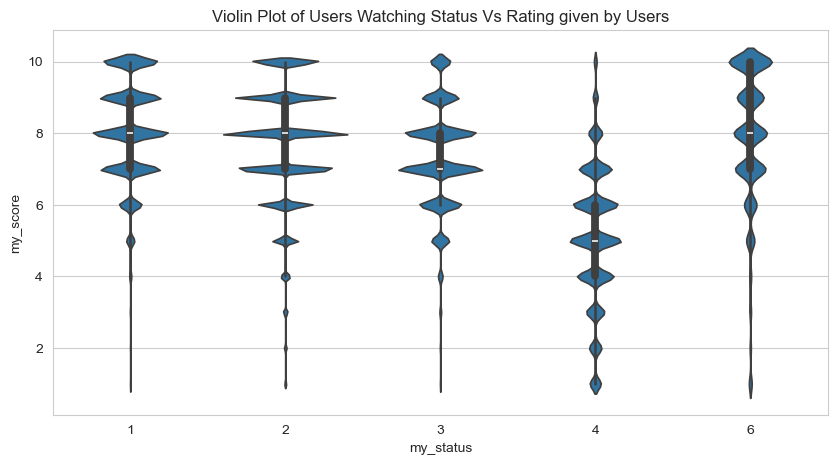

In [89]:
# plotting Violin Plot between users watching status vs rating given by users
fig = plt.figure(figsize=(10,5))
sns.violinplot(x="my_status", y="my_score", data=df_train)
plt.title('Violin Plot of Users Watching Status Vs Rating given by Users')
plt.show()

*observation*:From the above Violin Plot we can observe the distribution of different rating given by users on each value of users watching status.

And the distribution of different rating given by users on each value of users watching status has some variation from each other.

In [90]:
# creating dataframe of count of different rating given by on each users watching status
df_plot = df_train.groupby(['my_score', 'my_status']).size().reset_index().pivot(columns='my_score', index='my_status', values=0)
df_plot

my_score,1,2,3,4,5,6,7,8,9,10
my_status,,,,,,,,,,
1,582,594,945,2607,10666,29833,78492,100313,79860,71911
2,45581,67009,122081,279137,695425,1476408,3068723,3611600,2648656,1922301
3,713,962,2065,5797,22592,53446,106593,91144,46111,25432
4,24321,26906,40323,80510,114313,99625,71921,30405,10646,5938
6,1482,573,732,880,4359,6650,16343,17778,14292,22900


Text(0.5, 1.0, 'Stacked Bar Plot of Count of different Rating on Users Watching Status')

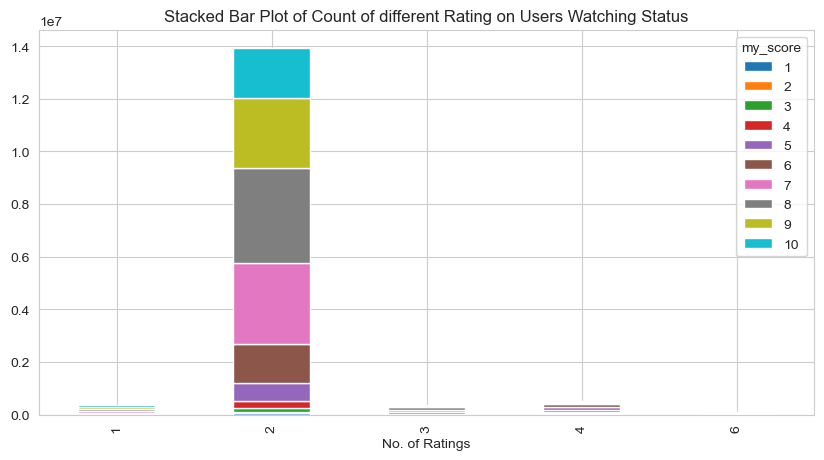

In [91]:
# plotting the Stacked Bar Plot of count of different rating given by users on each users watching status
df_plot.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.xlabel('No. of Ratings')
plt.title('Stacked Bar Plot of Count of different Rating on Users Watching Status')

*observation*: The above Stacked Bar Plot gives idea about the count of differnt rating given by users on each users watching status.

It can be seen that the most rated value by users in my_status=2(i.e. watching status is completed) is 8.

In [92]:
# Printing the average rating given by users on each watching status of users in descending order
avg_status = df_train.groupby(by=['my_status'])['my_score'].mean()
print("Average ratings w.r.t users waching status :")
print(avg_status.sort_values(ascending=False))

Average ratings w.r.t users waching status :
my_status
1    8.081785
6    7.957902
2    7.708499
3    7.355900
4    5.134278
Name: my_score, dtype: float64


*observation*: So the average rating value of my_status=4 is relatively lower than other status and it can also be easily seperated after observing the Box Plot.

## 4.6 Analysis of Rating on Anime Type

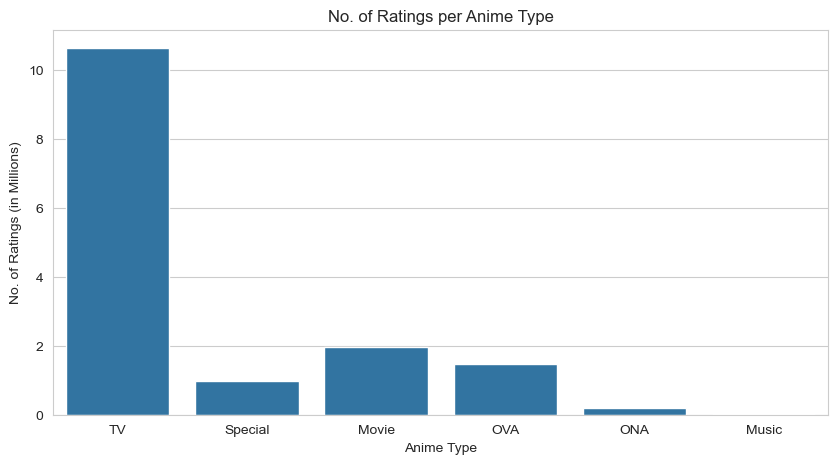

In [93]:
# plotting the distribution graph between anime type vs no. of rating given by users
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the count of each anime type in 'type'
sns.countplot(x='type', data=df_train, ax=ax)

# Set the title and labels
plt.title('No. of Ratings per Anime Type')
plt.xlabel('Anime Type')

# Format the y-axis to show values in millions
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x / 1e6))
ax.yaxis.set_major_formatter(ticks_y)

# Label the y-axis
plt.ylabel('No. of Ratings (in Millions)')

# Show the plot
plt.show()

*obervation*: The above graph shows that TV anime type is the most rated anime type by the users.

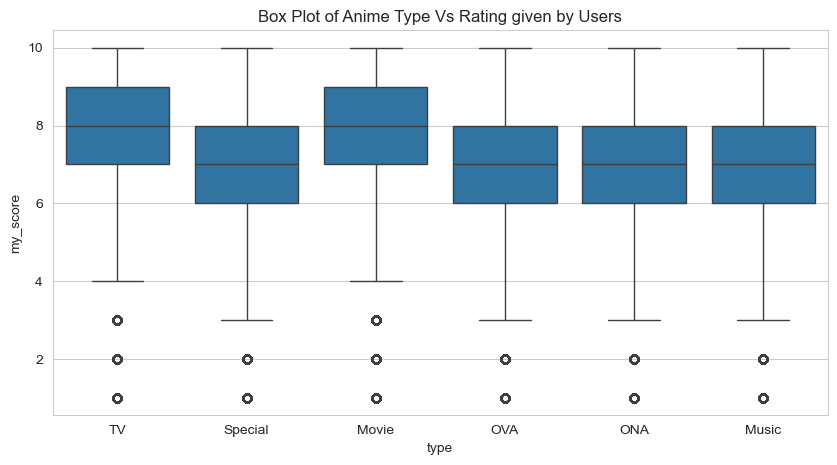

In [94]:
# plotting Box Plot between anime type vs rating given by users
fig = plt.figure(figsize = (10,5))
sns.boxplot(x='type', y ='my_score', data=df_train)
plt.title('Box Plot of Anime Type Vs Rating given by Users')
plt.show()

*obervation*: From the above graph it seems that TV and Movie anime type has similar Inter Quantile Range and different other anime type.

It can also be seen that Special, OVA, ONA and MUSIC anime type has similar Inter Quantile Range.

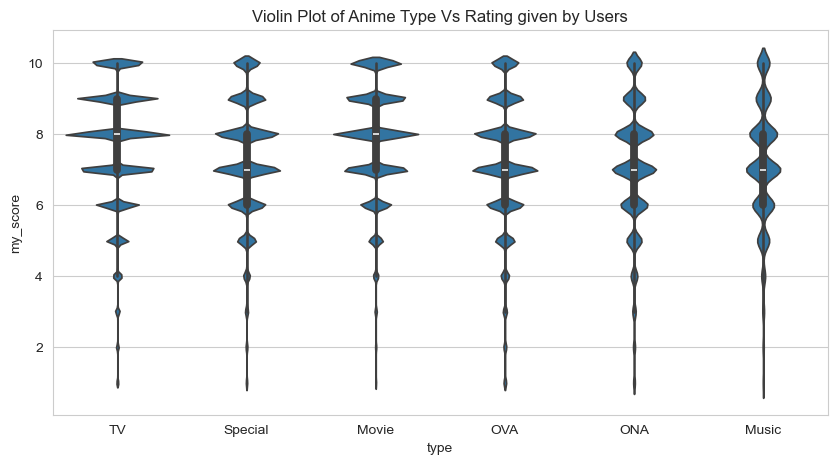

In [95]:
# plotting Violin Plot between anime type vs rating given by users
fig = plt.figure(figsize=(10,5))
sns.violinplot(x="type", y="my_score", data=df_train)
plt.title('Violin Plot of Anime Type Vs Rating given by Users')
plt.show()

*observation*: In Violin Plot it can be seen that the distribution of different rating given by users on each anime type has some variation from each other.

In [96]:
# creating dataframe of count of different rating given by on each anime type
df_plot = df_train.groupby(['my_score', 'type']).size().reset_index().pivot(columns='my_score', index='type', values=0)
df_plot

my_score,1,2,3,4,5,6,7,8,9,10
type,,,,,,,,,,
Movie,4148,6474,13060,32984,87970,188840,413317,512518,392891,307904
Music,178,241,396,919,2902,5234,8284,6693,3591,2990
ONA,1694,2009,3494,6982,16028,28849,46143,40728,23732,15885
OVA,13971,15376,22402,46127,107616,205219,364425,340884,204524,148021
Special,4576,6152,10860,24259,69267,138486,249287,232853,140138,96255
TV,48112,65792,115934,257660,563572,1099334,2260616,2717564,2034689,1477427


Text(0.5, 1.0, 'Stacked Bar Plot of Count of different Rating on each Anime Type')

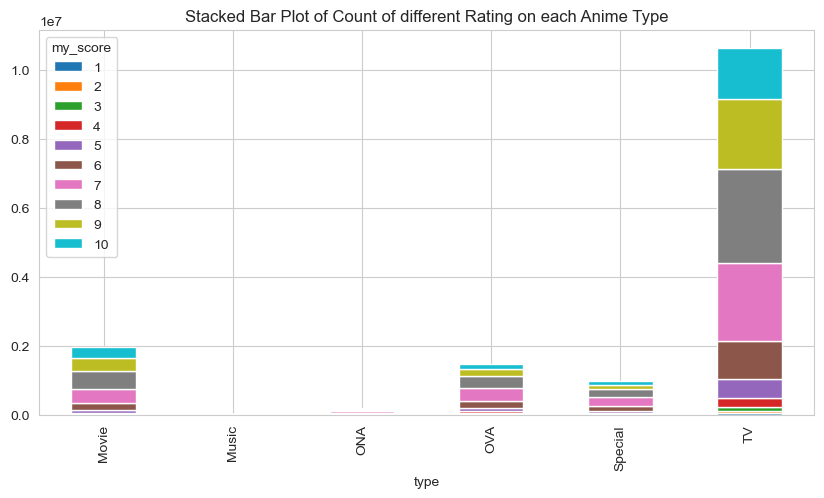

In [97]:
# plotting the Stacked Bar Plot of count of different rating given by users on each anime type
df_plot.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title('Stacked Bar Plot of Count of different Rating on each Anime Type')

*obervation*: The above Stacked Bar Plot gives idea about the count of differnt rating given by users on each anime types.

It can be seen that in each anime type has differnt most rated value i.e. 7 or 8.

In [98]:
# Printing the average rating given by users on each anime type in descending order
avg_status = df_train.groupby(by=['type'])['my_score'].mean()
print("Average ratings w.r.t anime type :")
print(avg_status.sort_values(ascending=False))

Average ratings w.r.t anime type :
type
Movie      7.841170
TV         7.670858
Special    7.360487
OVA        7.262058
Music      7.165235
ONA        7.106773
Name: my_score, dtype: float64


*obervation*: It can be observed that average rating value of different anime type does not show very significant variation.

## 4.7 Analysis of Rating on Anime Source

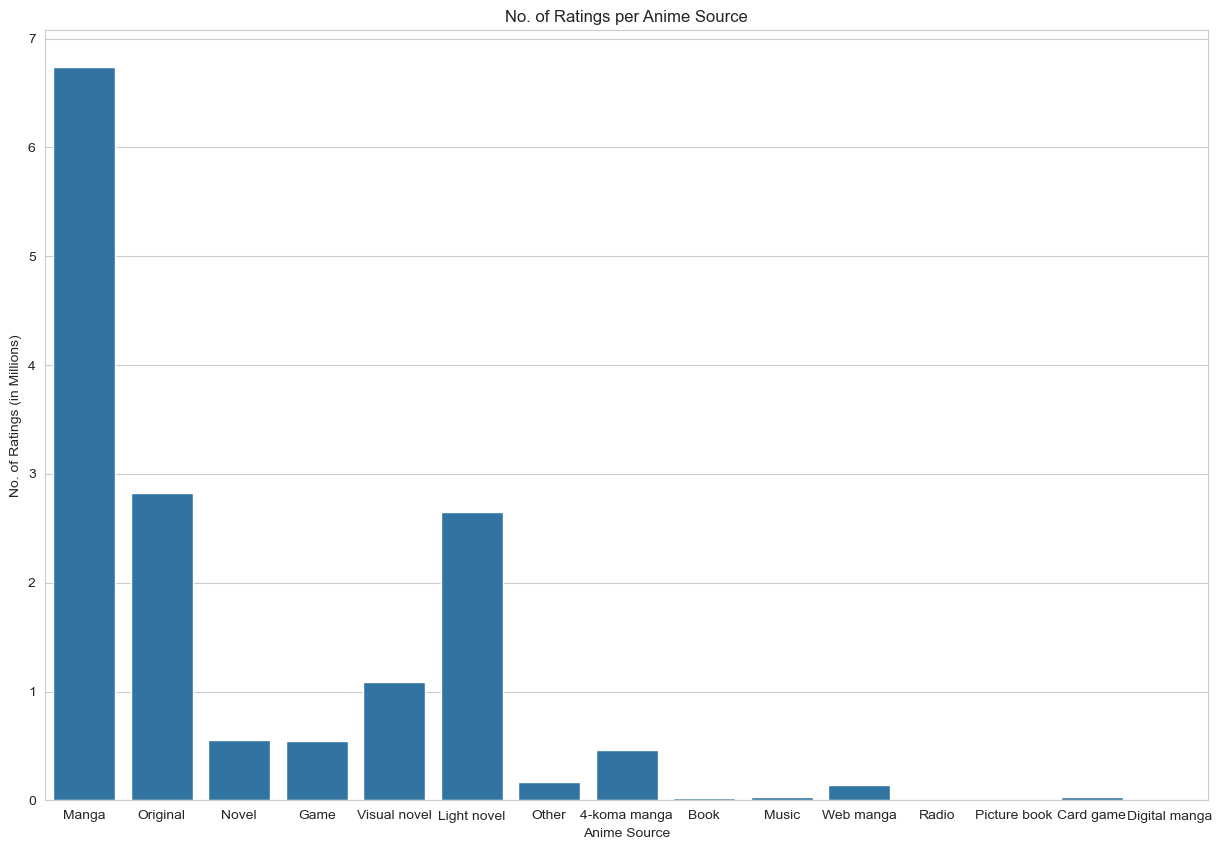

In [99]:
# Plotting the distribution of 'source' column (Anime Source)
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the count of each anime source in 'source'
sns.countplot(x='source', data=df_train, ax=ax)

# Set the title and labels
plt.title('No. of Ratings per Anime Source')
plt.xlabel('Anime Source')

# Format the y-axis to show values in millions
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x / 1e6))
ax.yaxis.set_major_formatter(ticks_y)

# Label the y-axis
plt.ylabel('No. of Ratings (in Millions)')

# Show the plot
plt.show()

*obervation*: The above graph looks very skewed as most count of users rating belongs to Manga, Original, Light Novel and Visual Novel.

But rest of the anime sources has very less count of users rating and in some cases even non existing count of users rating.

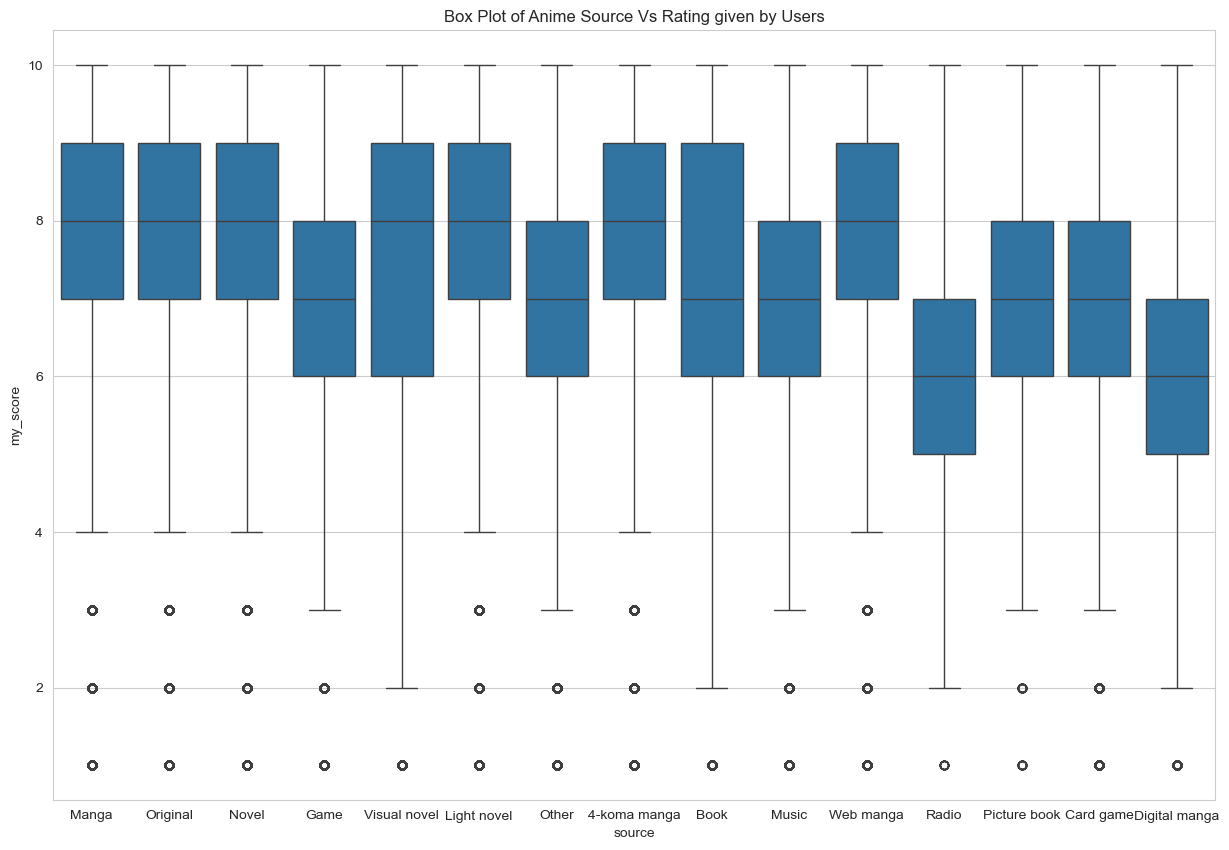

In [100]:
# plotting Box Plot between anime source vs rating given by users
fig = plt.figure(figsize = (15,10))
sns.boxplot(x='source', y ='my_score', data=df_train)
plt.title('Box Plot of Anime Source Vs Rating given by Users')
plt.show()

*obervation*: There are lot of anime sources which has same Inter Quantile Range and there are overlapping on each other.

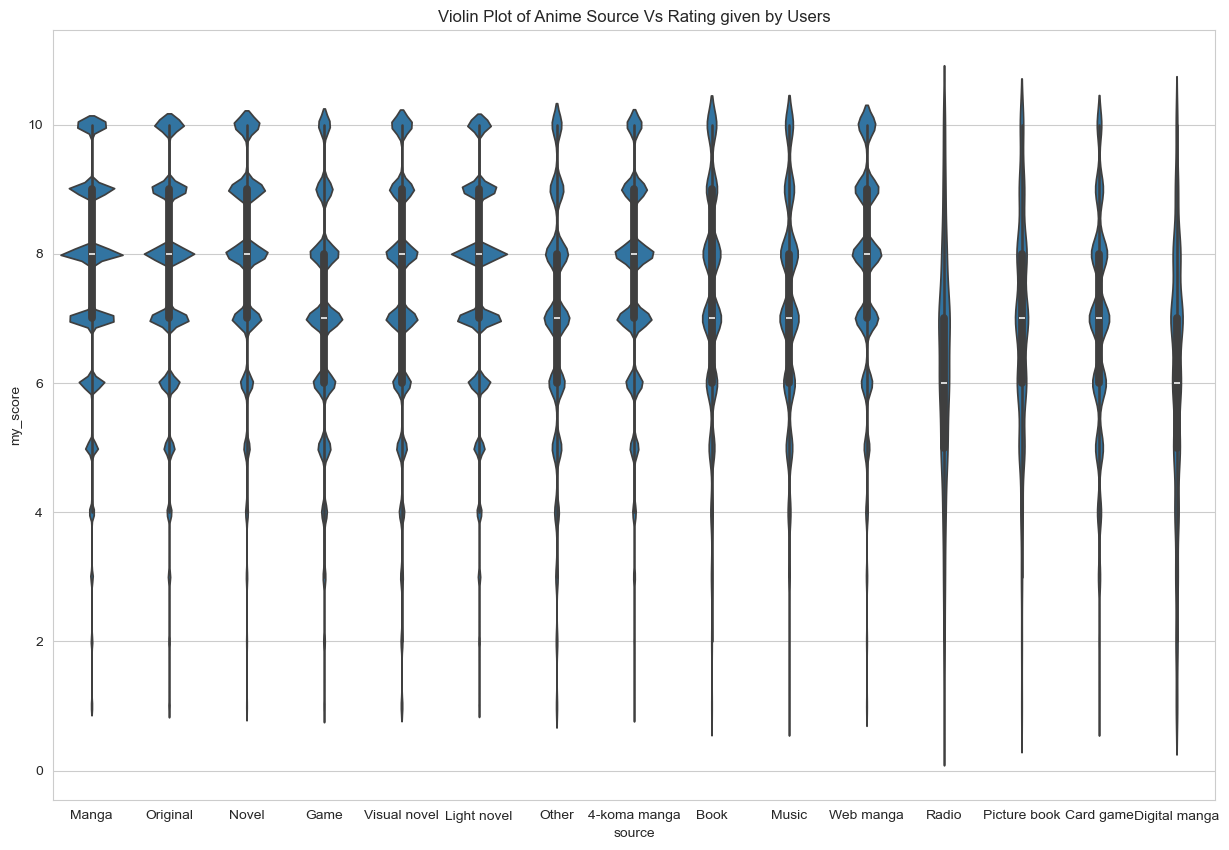

In [101]:
# plotting Violin Plot between anime source vs rating given by users
fig = plt.figure(figsize=(15,10))
sns.violinplot(x="source", y="my_score", data=df_train)
plt.title('Violin Plot of Anime Source Vs Rating given by Users')
plt.show()

*observation*: Variation in distribution can be seen in above Violin Plot of various anime sources

In [102]:
# creating dataframe of count of different rating given by on each anime source
df_plot = df_train.groupby(['my_score', 'source']).size().reset_index().pivot(columns='my_score', index='source', values=0)
df_plot

my_score,1,2,3,4,5,6,7,8,9,10
source,,,,,,,,,,
4-koma manga,1951,2573,4655,10130,26742,52825,108262,124195,78892,47629
Book,128,158,326,729,1850,3616,6198,5810,3597,3082
Card game,203,282,645,1315,2613,4649,6963,5491,2667,1522
Digital manga,119,181,219,378,605,798,1133,710,287,141
Game,3490,5373,9832,21419,49695,86987,139994,115426,64636,46069
Light novel,10598,15590,28475,62066,140754,289395,609009,708000,477302,304226
Manga,28074,36946,64506,147495,350494,708336,1469604,1723568,1268827,941696
Music,151,226,405,922,2173,3884,6493,5987,3348,2638
Novel,1494,1910,3889,8913,21167,45027,103846,150270,129258,92031


Text(0.5, 1.0, 'Stacked Bar Plot of Count of different Rating on each Anime Type')

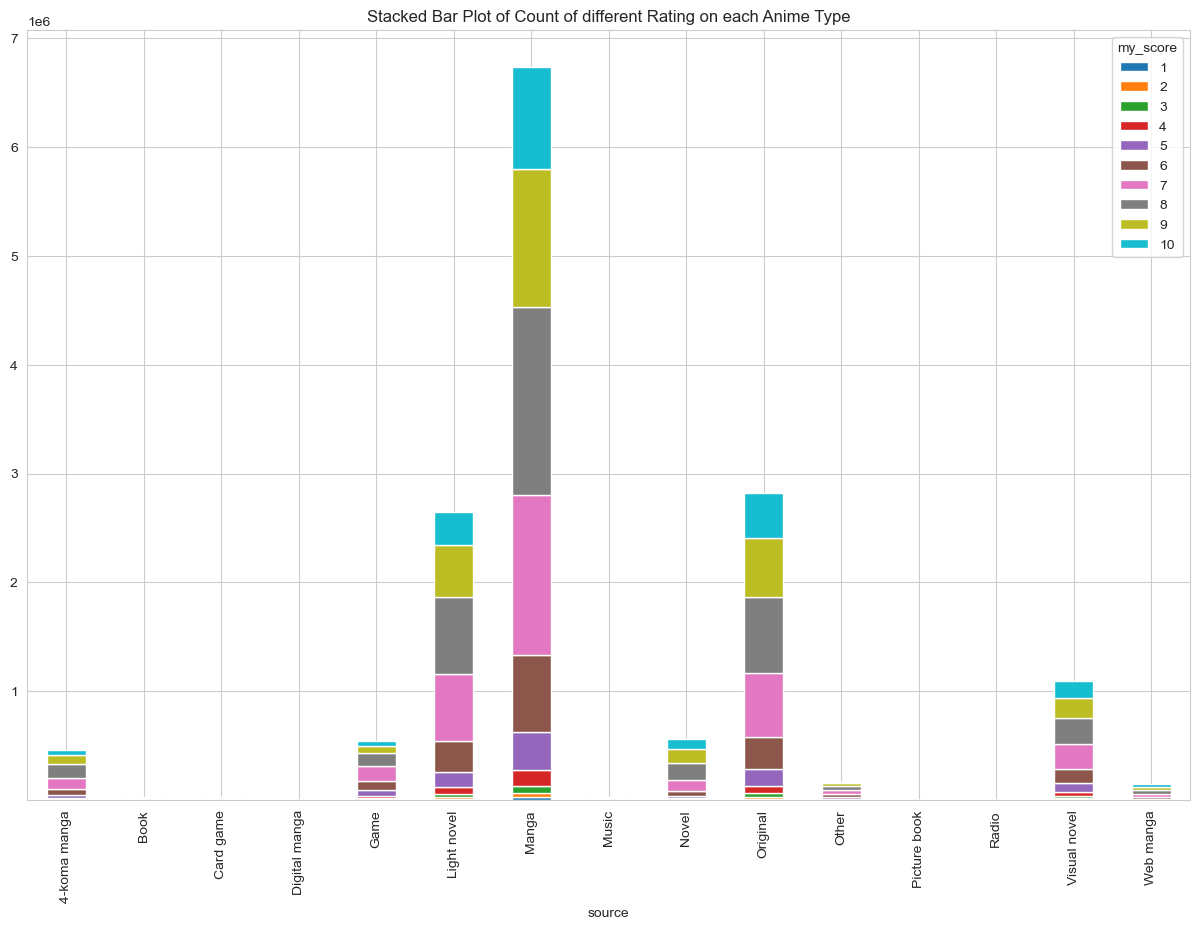

In [103]:
# plotting the Stacked Bar Plot of count of different rating given by users on each anime source
df_plot.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.title('Stacked Bar Plot of Count of different Rating on each Anime Type')

*observation*: The above Stacked Bar Plot gives idea about the count of differnt rating given by users on each anime sources.

It can be seen that each anime sources has differnt most rated value i.e. 7 or 8.

In [104]:
# Printing the average rating given by users on each anime source in descending order
avg_status = df_train.groupby(by=['source'])['my_score'].mean()
print("Average ratings w.r.t anime source :")
print(avg_status.sort_values(ascending=False))

Average ratings w.r.t anime source :
source
Novel            7.962180
Web manga        7.789951
Manga            7.685996
Original         7.683761
Light novel      7.590736
4-koma manga     7.535053
Visual novel     7.429276
Book             7.387738
Music            7.226675
Other            7.086112
Game             7.083139
Picture book     6.879346
Card game        6.861973
Radio            6.270633
Digital manga    6.140232
Name: my_score, dtype: float64


*observation*: The Average rating given by users on each sources varies a quite from with the highest average anime source value being 7.96 of Novel anime source and lowest average anime source value being 6.13 of Digital Manga anime source.

## 4.8 Analysis of Rating on Total No. of Episodes in each Anime

In [105]:
# creating the dataset of toatal number of rating given to each anime in decreasing order
ratings_per_anime_episodes = df_train.groupby(by='episodes')['my_score'].count().sort_values(ascending=False)
ratings_per_anime_episodes

episodes
12     3468254
1      3191208
13     1881199
26     1136556
24     1082084
        ...   
215          3
263          1
199          1
164          1
151          1
Name: my_score, Length: 157, dtype: int64

In [106]:
print("Total number different no. of episodes in animes is : ", len(ratings_per_anime_episodes))

Total number different no. of episodes in animes is :  157


Text(0, 0.5, 'No. of Rating given by User (in Million)')

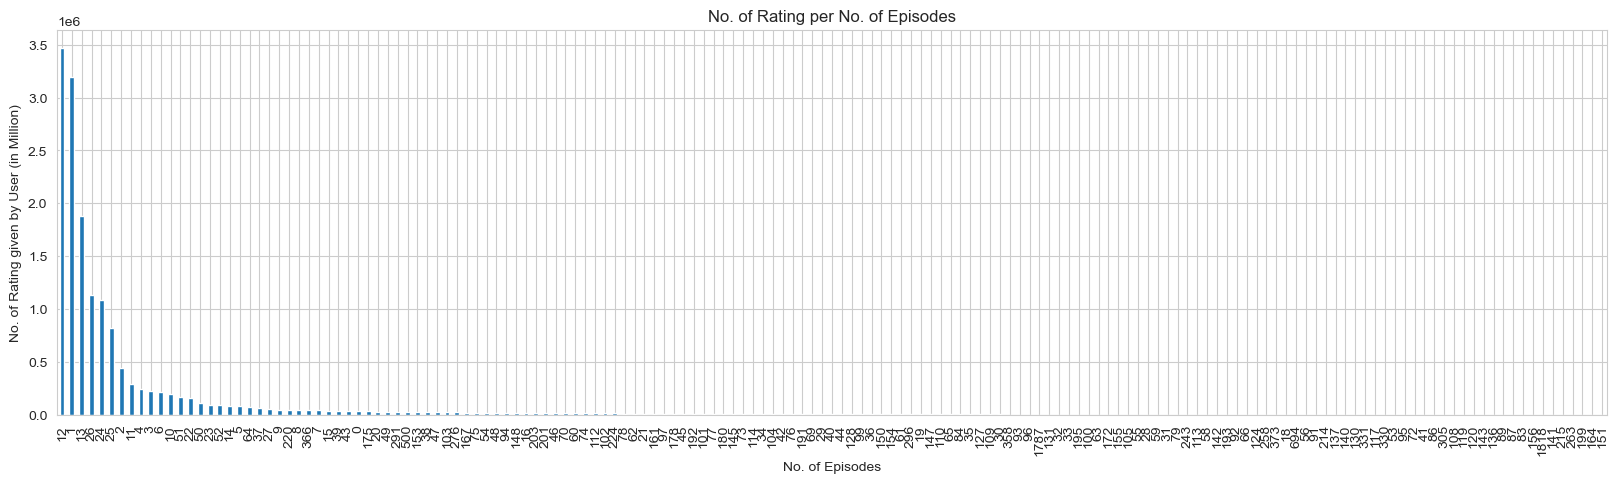

In [107]:
# Plotting the bar plot of no. of rating given by user on each no. episodes
ratings_per_anime_episodes.plot(kind = 'bar', figsize = (20,5), title = 'No. of Rating per No. of Episodes')
plt.xlabel('No. of Episodes')
plt.ylabel('No. of Rating given by User (in Million)')

Text(0, 0.5, 'No. of Rating given by User (in Million)')

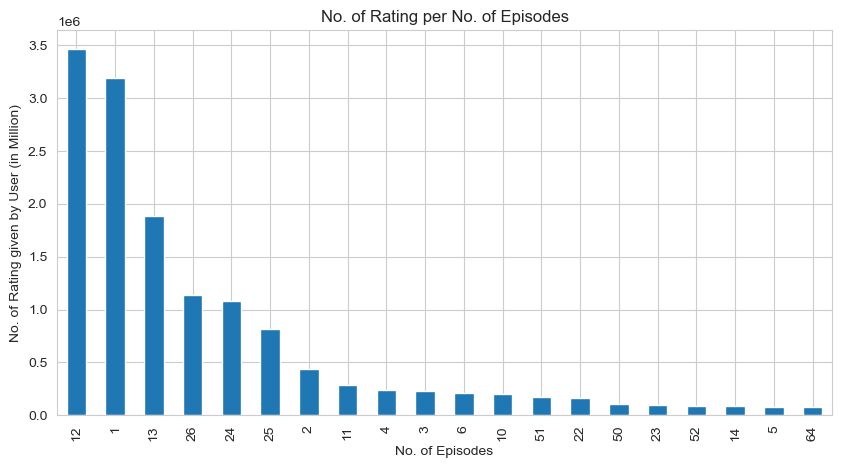

In [108]:
# Plotting the bar plot of Top 20 no. of rating given by user on each no. episodes
ratings_per_anime_episodes[:20].plot(kind = 'bar', figsize = (10,5), title = 'No. of Rating per No. of Episodes')
plt.xlabel('No. of Episodes')
plt.ylabel('No. of Rating given by User (in Million)')

*obervation*: It can be oberve that for a 12 episodes , max rating is about 3.5

## 4.9 Analysis of Rating on Anime Studios

In [109]:
# grouping and counting the rating given by users on different anime studios
studio_rated_by_users = df_train.groupby(by='studio')['my_score'].count().sort_values(ascending=False)
studio_rated_by_users

studio
Madhouse                                1014811
J.C.Staff                                883526
Toei Animation                           676143
Studio Deen                              650757
Sunrise                                  614110
                                         ...   
J.C.Staff, Kitty Films                        1
Larx Entertainment                            1
Toei Animation, Tatsunoko Production          1
Studio Pierrot, Studio Gallop                 1
NUT                                           1
Name: my_score, Length: 591, dtype: int64

*observation*: As it can be seen that there are various animes with more than one studio.

So, we need to seperate the each studio and count the rating given by users on each studios.

In [110]:
# creating the list of unique anime studios
studio = df_train['studio'].values
studio_list = [] 

for i in tqdm(range(len(studio))):
    stu = studio[i].split(", ")
    for j in range(len(stu)):
        if stu[j] not in studio_list:
            studio_list.append(stu[j])

100%|██████████| 15258476/15258476 [00:13<00:00, 1163591.63it/s]


In [111]:
# checking the total number of unique anime studios
len(studio_list)

381

In [112]:
# creating list of count of rating given by users on unique anime studios
studio_count = []
for i in tqdm(range(len(studio_list))):
    count = 0
    for j in range(len(df_train)):
        if studio_list[i] in studio[j]:
            count += 1
    studio_count.append(count)

100%|██████████| 381/381 [08:30<00:00,  1.34s/it]


In [113]:
# creating dataframe of studio and their count of rating given by users
df_studio = pd.DataFrame({'Studio' : studio_list, 'Studio Count' : studio_count})
df_studio = df_studio.set_index('Studio')
df_studio.sort_values(by = 'Studio Count', ascending = False, inplace = True)
df_studio.head()

,Studio Count
Studio,
Madhouse,1094552
J.C.Staff,904172
A-1 Pictures,711650
Toei Animation,688594
Studio Deen,679393


Text(0, 0.5, 'No. of rating by Users (in Millions)')

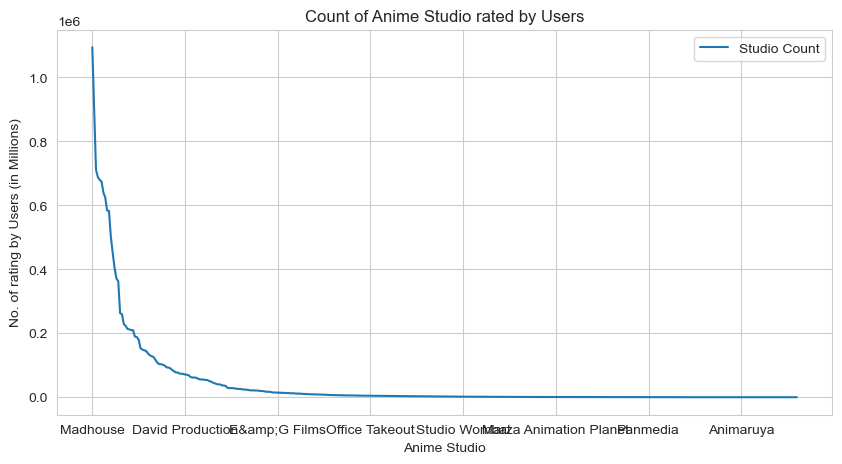

In [114]:
# plotting the distribution of rating given by users on unique anime studios
df_studio.plot(figsize = (10,5), title = "Count of Anime Studio rated by Users")
plt.xlabel("Anime Studio")
plt.ylabel("No. of rating by Users (in Millions)")

*observation*:The above graph is very skewed as their are very few studios which has most counts of users rating.

Text(0, 0.5, 'No. of rating by Users (in Million)')

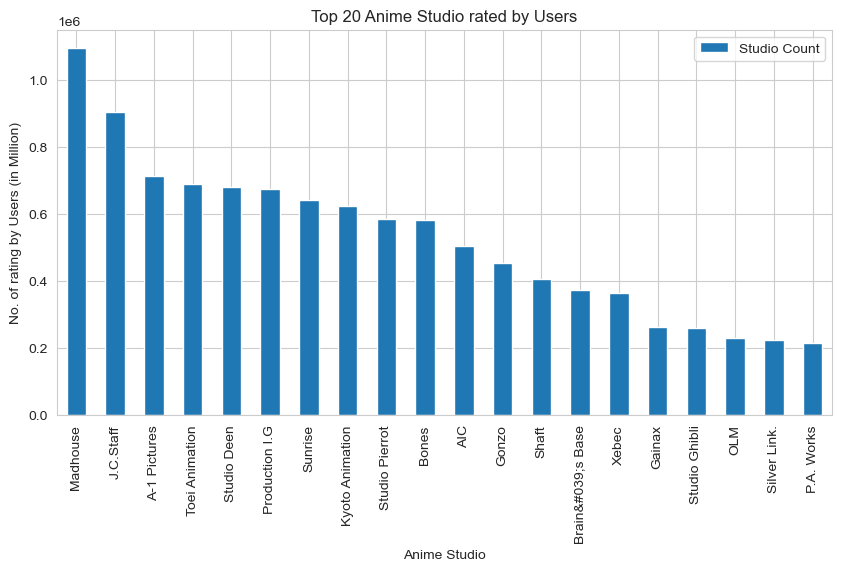

In [115]:
# plotting the bar plot of top 20 anime studio rated by users
df_studio[:20].plot.bar(figsize = (10,5), title = "Top 20 Anime Studio rated by Users")
plt.xlabel("Anime Studio")
plt.ylabel("No. of rating by Users (in Million)")

# 4.10 Analysis of Rating on Genres in Anime
For each anime their are various animes genre that can be associate to particular anime.

So, we need to seperate the each anime genre and count the rating given by users on each genre.

In [116]:
# creating the list of unique anime genres
genres = df_train['genre'].values
genre_list = [] 

for i in tqdm(range(len(genres))):
    gen = genres[i].split(", ")
    for j in range(len(gen)):
        if gen[j] not in genre_list:
            genre_list.append(gen[j])

100%|██████████| 15258476/15258476 [00:17<00:00, 852366.44it/s]


In [117]:
# checking the total number of unique anime genres
len(genre_list)

43

In [118]:
# creating list of count of ratings given by users on unique anime genres
genre_count = []
for i in tqdm(range(len(genre_list))):
    count = 0
    for j in range(len(df_train)):
        if genre_list[i] in genres[j]:
            count += 1
    genre_count.append(count)

100%|██████████| 43/43 [01:16<00:00,  1.78s/it]


In [119]:
# creating dataframe of studio and their count of rating given by users
df_genre = pd.DataFrame({'Genre':genre_list, 'Genre Count':genre_count})
df_genre = df_genre.set_index('Genre')
df_genre.sort_values(by = 'Genre Count',ascending = False,inplace=True)
df_genre.head()

,Genre Count
Genre,
Comedy,7902177
Action,6431097
Romance,4987757
Drama,4456123
Fantasy,3864590


Text(0, 0.5, 'No. of rating by Users (in Millions)')

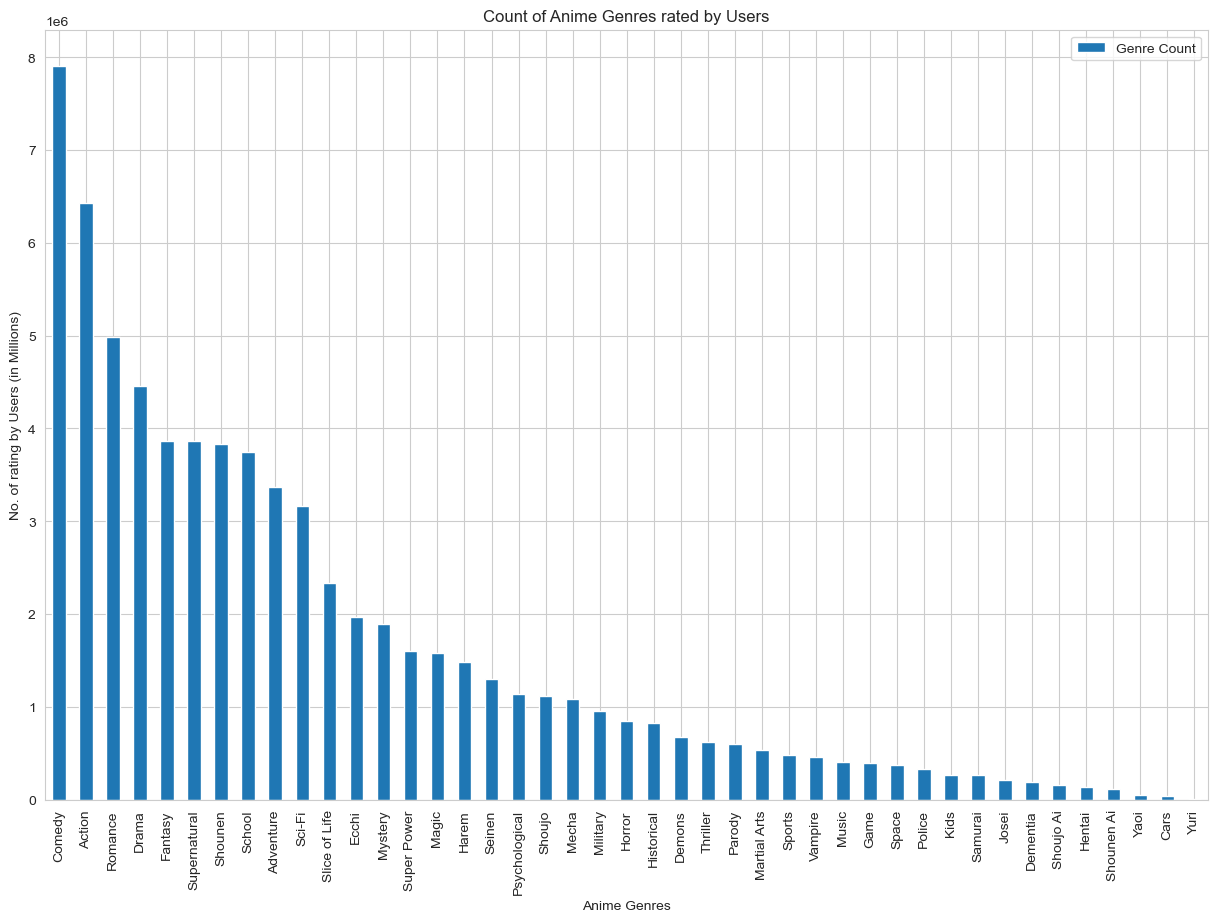

In [120]:
# plotting the distribution of rating given by users on unique anime genres
df_genre.plot.bar(figsize = (15,10), title = "Count of Anime Genres rated by Users")
plt.xlabel("Anime Genres")
plt.ylabel("No. of rating by Users (in Millions)")

Text(0, 0.5, 'No. of rating by Users (in Millions)')

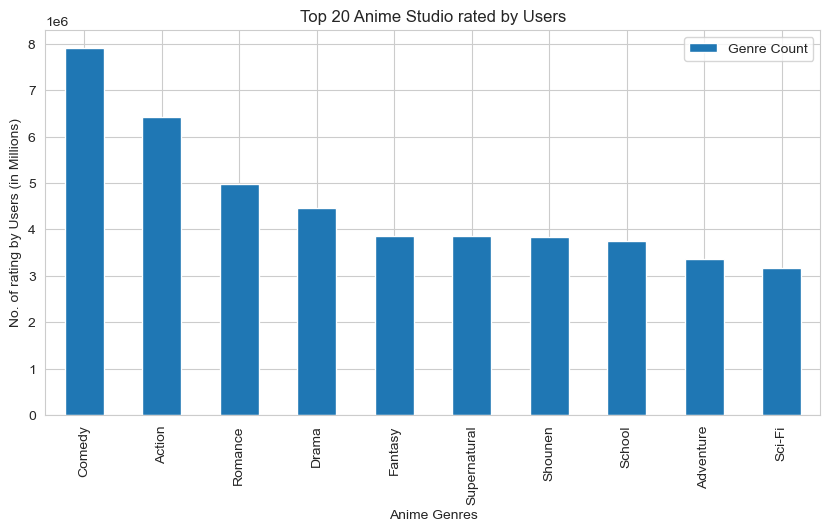

In [121]:
# plotting the bar plot of top 10 anime genres rated by users
df_genre[:10].plot.bar(figsize = (10,5), title = "Top 20 Anime Studio rated by Users")
plt.xlabel("Anime Genres")
plt.ylabel("No. of rating by Users (in Millions)")

*observation*: Comedy is most rated genre

## 4.11 Analysis of Rating on Users Gender

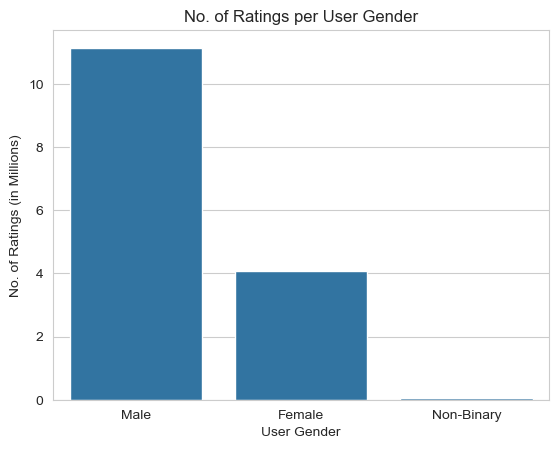

In [122]:
# plotting the distribution graph between users gender vs no. of rating given by users
fig, ax = plt.subplots()

# Plot the count of each gender in 'gender'
sns.countplot(x='gender', data=df_train, ax=ax)

# Set the title and labels
plt.title('No. of Ratings per User Gender')
plt.xlabel('User Gender')

# Format the y-axis to show values in millions
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x / 1e6))
ax.yaxis.set_major_formatter(ticks_y)

# Label the y-axis
plt.ylabel('No. of Ratings (in Millions)')

# Show the plot
plt.show()

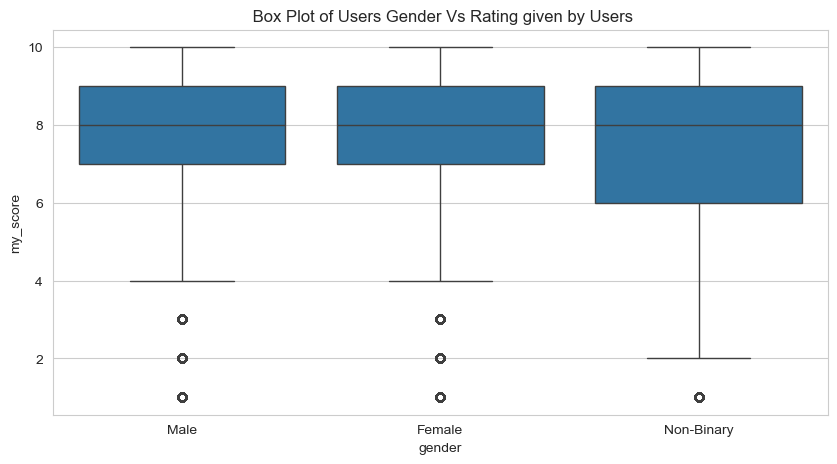

In [123]:
# plotting Box Plot between users gender vs rating given by users
fig = plt.figure(figsize=(10,5))
sns.boxplot(x='gender', y ='my_score', data=df_train)
plt.title(' Box Plot of Users Gender Vs Rating given by Users')
plt.show()

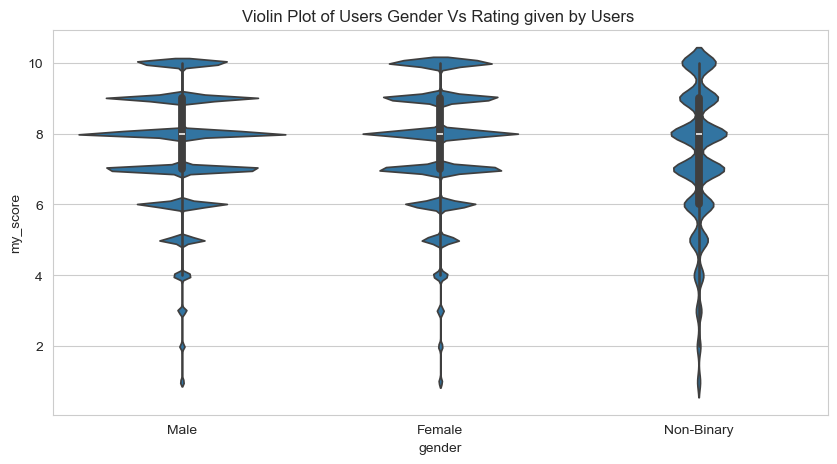

In [124]:
# plotting Violin Plot between anime source vs rating given by users
fig = plt.figure(figsize=(10,5))
sns.violinplot(x="gender", y="my_score", data=df_train)
plt.title('Violin Plot of Users Gender Vs Rating given by Users ')
plt.show()

In [125]:
# creating dataframe of count of different rating given by on user gender
df_plot = df_train.groupby(['my_score', 'gender']).size().reset_index().pivot(columns='my_score', index='gender', values=0)
df_plot

my_score,1,2,3,4,5,6,7,8,9,10
gender,,,,,,,,,,
Female,20589,26587,41624,95993,232555,439467,833211,952787,763681,654237
Male,51438,68661,123281,270758,610582,1219675,2497048,2885504,2026949,1386430
Non-Binary,652,796,1241,2180,4218,6820,11813,12949,8935,7815


Text(0.5, 1.0, 'Stacked Bar Plot of Count of different Rating w.r.t Users Gender')

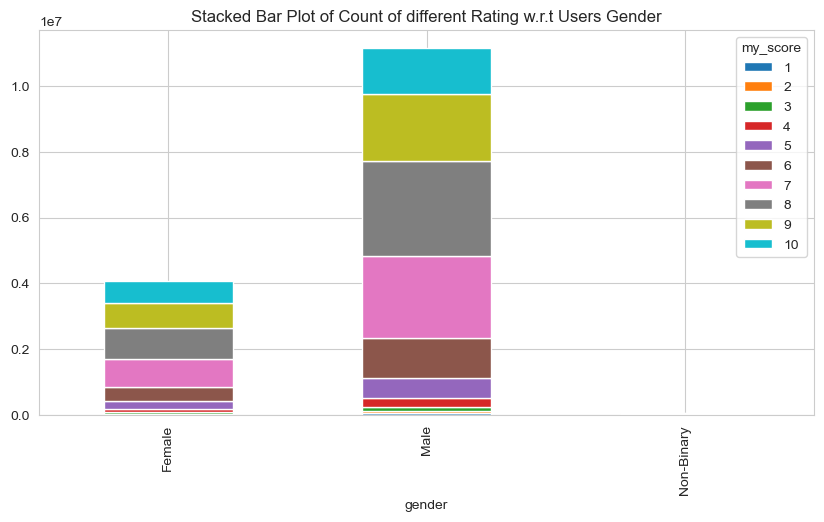

In [126]:
# plotting the Stacked Bar Plot of count of different rating given by users w.r.t. users gender
df_plot.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title('Stacked Bar Plot of Count of different Rating w.r.t Users Gender')

In [127]:
# Printing the average rating given by users as per users gender in descending order
avg = df_train.groupby(by=['gender'])['my_score'].mean()
print("Average ratings w.r.t user gender :")
print(avg.sort_values(ascending=False))

Average ratings w.r.t user gender :
gender
Female        7.696264
Male          7.601466
Non-Binary    7.341559
Name: my_score, dtype: float64


## 4.12 Plotting Correlation between multiple Features

In [128]:
# copying train dataframe for creating dataframe for correlation calculation
df_train_corr = df_train.copy()

# Applying Label Encoding of categorical features variables
enconder = LabelEncoder()
username_labels = enconder.fit_transform(df_train_corr['username'])
type_labels = enconder.fit_transform(df_train_corr['type'])
source_labels = enconder.fit_transform(df_train_corr['source'])
gender_labels = enconder.fit_transform(df_train_corr['gender'])

# appending label encoded feature on correlation dataframe
df_train_corr['username_labels'] = username_labels
df_train_corr['type_labels'] = type_labels
df_train_corr['source_labels'] = source_labels
df_train_corr['gender_labels'] = gender_labels

# droping the categorical features after appending its label encoded features
df_train_corr = df_train_corr.drop(['username','my_last_updated','title','type','source','studio','genre','gender'], axis = 1)
df_train_corr.head(2)

,anime_id,my_watched_episodes,my_score,my_status,episodes,user_id,username_labels,type_labels,source_labels,gender_labels
0,65,12,9,2,12,390,83184,5,6,1
1,50,9,6,4,24,3,4654,5,6,1


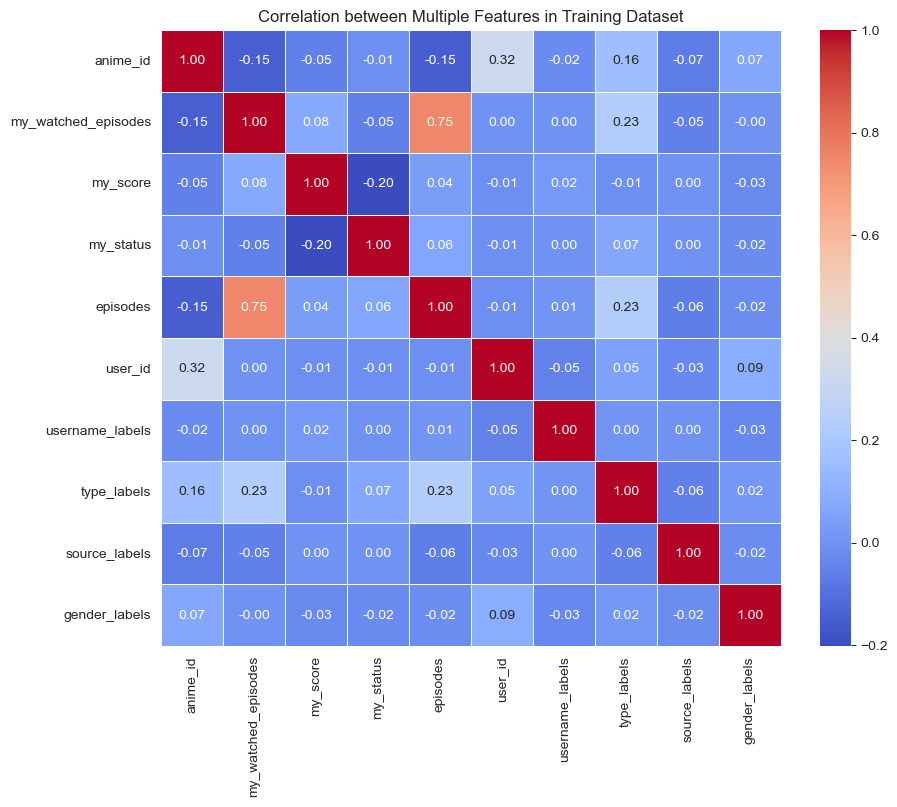

In [130]:
# plotting the correlation heatmap for visualising the relationship between the various features
plt.figure(figsize=(10, 8))  # Adjust width and height as needed

# Calculate the correlation matrix
cor = df_train_corr.corr()

# Plot the heatmap with annotations
sns.heatmap(cor, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True)

# Set the title of the plot
plt.title('Correlation between Multiple Features in Training Dataset')

# Display the plot
plt.show()

*observation*:From the above Correlation Heatmap, we can observe that the Highest Correlation of about 75% is between No. of Episodes in Anime (i.e. 'episodes' feature)and No. of Episodes watched by User (i.e. 'my_watched_episodes' feature) in given anime.

So we will drop the 'my_watched_episodes' column as it is highly corelated with 'episodes' column and we will retain the 'episodes' column.

And the Least Correlation value of about 0.075% is between 'source_label' and 'my_status' features.

In [131]:
# dropping the 'my_watched_episodes' column from train and test dataset
df_train = df_train.drop(['my_watched_episodes'], axis = 1)
df_test = df_test.drop(['my_watched_episodes'], axis = 1)

df_train.head(2)

,username,anime_id,my_score,my_status,my_last_updated,title,type,source,episodes,studio,genre,user_id,gender
0,martino,65,9,2,2006-09-27,Rozen Maiden: Träumend,TV,Manga,12,Nomad,"Action, Comedy, Drama, Magic, Seinen",390,Male
1,Aokaado,50,6,4,2006-09-27,Aa! Megami-sama! (TV),TV,Manga,24,AIC,"Comedy, Supernatural, Magic, Romance, Seinen",3,Male


## 4.13 Finding various Average values
Finding different average values to get generalize idea about the dataset.


### 4.13.1 Finding Global Average of all Anime Ratings given by Users

In [132]:
print('The Global Average of all Anime Rating given by Users is : ', df_train['my_score'].mean())

The Global Average of all Anime Rating given by Users is :  7.625716028258655


### 4.13.2 Finding Average No. of Rating given by each Users

In [133]:
anime_rated_by_users = df_train.groupby(by = 'username')['my_score'].count().sort_values(ascending = False)
anime_rated_by_users

username
_thiagobrisolla    2845
Kannei             2716
Shouichirou        2701
GrumpyAnimeSnob    2595
ShanaFlame         2588
                   ... 
Felini                1
RRS_007               1
REVIKATYA             1
keviceaia             1
anecdot11             1
Name: my_score, Length: 99171, dtype: int64

In [134]:
print('The Average No. of Rating given by each Users is : ', np.round(anime_rated_by_users.mean()))

The Average No. of Rating given by each Users is :  154.0


### 4.13.3 Finding Average No. of Rating given on each Animes

In [135]:
ratings_per_anime = df_train.groupby(by='title')['my_score'].count().sort_values(ascending=False)
ratings_per_anime

title
Death Note                                            61549
Code Geass: Hangyaku no Lelouch                       47130
Naruto                                                46960
Elfen Lied                                            45983
Sword Art Online                                      44796
                                                      ...  
Kaitou Joker 4th Season                                   1
Jakusansei Million Arthur                                 1
Isobe Isobee Monogatari: Ukiyo wa Tsurai yo (2015)        1
Imakara Atashi......                                      1
ēlDLIVE                                                   1
Name: my_score, Length: 5594, dtype: int64

In [136]:
print('The Average No. of rating given on each anime is : ',  np.round(ratings_per_anime.mean()))

The Average No. of rating given on each anime is :  2728.0


### 4.13.4 Finding Average No. of Episodes in each Anime

In [137]:
episodes_per_anime = df_train.groupby(by='title')['episodes'].max().sort_values(ascending=False)
episodes_per_anime

title
Oyako Club                                               1818
Doraemon (1979)                                          1787
Ninja Hattori-kun                                         694
Naruto: Shippuuden                                        500
Kochira Katsushikaku Kameari Kouenmae Hashutsujo (TV)     373
                                                         ... 
Neko Konogoro                                               0
Kareshi wa Hammerhead Shark                                 0
Gudetama                                                    0
One Piece                                                   0
Sazae-san                                                   0
Name: episodes, Length: 5594, dtype: int64

In [138]:
print('The Average No. of episodes on each anime is : ', np.round(episodes_per_anime.mean()))

The Average No. of episodes on each anime is :  15.0


## Cold Start Problem

The **cold start problem** in the context of recommendation systems refers to the challenge that occurs when there is insufficient data to make accurate recommendations for users, items, or both. In the case of an **Anime Recommendation System**, it means that when new users or new anime titles are introduced to the system, the system doesn't have enough historical data (like user preferences or item interactions) to recommend relevant content.

The cold start problem can be broken down into three categories:

### 1. **User Cold Start**:
   - **Problem**: When a new user joins the platform and has not interacted with any anime titles yet (i.e., they haven't rated or watched anything). The system struggles to make personalized recommendations for them.
   - **Example**: A new user signs up for your anime recommendation system, but they haven't rated any anime shows or movies yet, so the system has no idea what their preferences are.

### 2. **Item Cold Start**:
   - **Problem**: When a new anime title is added to the platform but has no ratings or interactions from users. The system doesn't have any feedback to help recommend the anime to others.
   - **Example**: A new anime series is released on your platform, but since no one has rated or watched it yet, the system can't recommend it to users who might enjoy it.

### 3. **System Cold Start**:
   - **Problem**: When the recommendation system itself is newly launched, and there is no data on either users or items. It’s difficult to make any recommendations because there’s no history to learn from.
   - **Example**: When you first launch your anime recommendation system, there are no user preferences or anime interactions in the system, making it difficult to suggest relevant content to new users.

### Solving the Cold Start Problem in an Anime Recommendation System:
1. **Hybrid Systems**: Combine collaborative filtering (based on user-item interactions) with content-based filtering (based on attributes like anime genre, tags, or description) to make recommendations even when there is no interaction data.
  
2. **Popularity-Based Recommendations**: Recommend the most popular or highly-rated anime titles as a default when you don't have enough information about a user or a new anime.

3. **Use Metadata**: For new users, use their demographic data (age, gender, etc.) to make recommendations. For new anime, you could recommend based on metadata like genre, creator, or similar shows.

4. **Active Learning**: Encourage new users to provide some initial ratings or to watch a few anime shows. This can jump-start their profile and allow the system to start making better recommendations.

5. **Cross-Domain Recommendations**: If your platform has other types of content (like manga or movies), use their data to inform anime recommendations.



## 4.14 Analysing Cold Start Problem

### 4.14.1 Cold Start Problem for Users

In [139]:
users_in_train = set(np.unique(df_train.user_id))
users_in_test = set(np.unique(df_test.user_id))
new_users = len(users_in_test - users_in_train)

print('Total number of Users in Train dataset :', len(users_in_train))
print('Total number of Users in Test dataset :', len(users_in_test))
print('Total number of New Users for Training dataset :', new_users)

Total number of Users in Train dataset : 99171
Total number of Users in Test dataset : 56789
Total number of New Users for Training dataset : 7177


In [140]:
print('Percentage of New Users for Training Dataset : ', new_users/(len(users_in_train) + new_users)*100,'%')

Percentage of New Users for Training Dataset :  6.748598939331252 %


### 4.14.2 Cold Start problem with Animes

In [141]:
anime_in_train = set(np.unique(df_train.anime_id))
anime_in_test = set(np.unique(df_test.anime_id))
new_anime = len(anime_in_test - anime_in_train)

print('Total number of Anime in Train dataset :', len(anime_in_train))
print('Total number of Anime in Test dataset :', len(anime_in_test))
print('Total number of New Anime for Training dataset : ', new_anime)

Total number of Anime in Train dataset : 5594
Total number of Anime in Test dataset : 6552
Total number of New Anime for Training dataset :  998


In [142]:
print('Percentage of New Animes for Training Dataset : ', new_anime/(len(anime_in_train) + new_anime)*100,'%')

Percentage of New Animes for Training Dataset :  15.139563106796118 %
